# Project 2 Regression Challenge
## Daniel Rossetti

# 0 - Problem Statement:

This is report is written from the standpoint of a data science consultant who has been hired by Zillow to prototype a home sale price estimator that can be used by website users to estimate the value of their home.  Home sale data from Ames, Iowa have been provided as a starter set and include information on almost 80 different attributes of the home or the sale itself.  This data will be used to train a linear regression model which will use a subset of these attributes to predict a home sale price.  The model quality will be evaluated against the mean absolute error of the predictions on the training dataset selected.  The target error is to be within $30,000 of the actual home price on average.  If successful, the methods used to create this prototype model will be employed to predict home values in other areas of the country to understand it's general applicability with the ultimate goal of being rolled out onto the Zillow website for users.

# 1 - Import Libraries, Data Source(s), and Read Data

## 1.1 - Import Libraries

In [121]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

# Supress warnings with justification:
# Convergence warnings were thrown for the lasso regularization function
# A future wanring was thrown for pandas formatting issues
import warnings
warnings.filterwarnings('ignore')

## 1.2 - Data Source(s)

The provided data are home sales in the city of Ames, Iowa between 2006 and 2010.  The data can be found [here](https://www.kaggle.com/competitions/dsir-320-project-2-regression-challenge/data).

## 1.3 - Read Data

In [2]:
# Read Training Data
train = pd.read_csv('../datasets/train.csv')

# Retrieve the shape of the dataset to evaluate size
print(train.shape)

train.head()

(2051, 81)


Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [3]:
# Read Test Data
test = pd.read_csv('../datasets/test.csv')

# Retrieve the shape of the dataset to evaluate size
print(test.shape)
test.head()

(878, 80)


Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   
2   NaN          NaN        0       9     2006        New  
3   NaN          NaN        0       7     2007        WD   
4   NaN          NaN        0       7     2009        WD   

[5 rows x 80 columns]

# 2 - Data Pre-processing, EDA, and Preliminary Model Feature Selection

### Strategy:
* Initial checks and evaluations must be performed on the whole dataset
* Light data cleaning will occur to remove features that are not usable until columns of interest are properly formatted
* Analysis will be performed prior to down-selecting the attributes (columns / features) that will be used in the first model.  Specifically:
    * Numerical features will be correlated to the sale price and to each other to determine which have the greatest impact on the sale price
    * Categorical features will be examined which would intuitively appear to correlate well with sale price
    * An initial dataset will be created attempting to balance numerical and catgeorical features while keeping the total number of features at or below the square root of the training data sample size
    
### NOTE:  A major underlying theme of picking the initial model features is to select features which characterize all major (phyiscal) features of a home such as the basement, garage, bedrooms, location, etc.  The goal is to make a model that is holistic and includes most of typical categories that home-buyers and evaluators consider.  This is an intuitive decision that will be refined by examining the correlations between these variables and the sale price.

## 2.1 - Check Dataframe Integrity, Check for Null Values

### 2.1.1 - Check Data Integrity (Data Types)

In [4]:
# View the columns, check non-null counts and data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

Most of the features are of the correct data type save for the following which need to be reassigned:
* MS SubClass - The building class is actually a categorical variable and needs to be turned into an object
    * Change this to an object type (convert to string)
* Mo Sold - The month sold is also a categorical variable
    * Change this to an object type (convert to string)
    
### A Note on Descrete Numerical Variables:
'Overall Qual' and 'Overall Cond' are technically categorical variables, but as they are discrete numerical variables which effectively establish a quality/condition spectrum, it will be argued that these should be left as numerical datatypes.

Some Variables ('Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars') are float values when they likely should be represented as integers.  The code below will investigate what float values if any are present.

In [5]:
# The code below creates a list of items in each catgeory (column) which will have a remainder greater than 0 when divided by 1
#  This will indicate if the number is truly a decimal or if something else is happening.  It's then converted to a set.
print(set([i for i in train['Bsmt Full Bath'] if i % 1 != 0]))
print(set([i for i in train['Bsmt Half Bath'] if i % 1 != 0]))
print(set([i for i in train['Garage Yr Blt'] if i % 1 != 0]))
print(set([i for i in train['Garage Cars'] if i % 1 != 0]))

{nan, nan}
{nan, nan}
{nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan}
{nan}


From this, NaN values (which are technically float64) are causing these columns to be float instead of integer.  Overall, these values are fine, but the null values should now be checked.

Below, 'MS SubClass' and 'Mo Sold' will be converted to objects.

In [6]:
# Convert MS SubClass and Mo Sold to objects, using list comprehension
train['MS SubClass'] = [str(i) for i in train['MS SubClass']]
train['Mo Sold'] = [str(i) for i in train['Mo Sold']]
test['MS SubClass'] = [str(i) for i in test['MS SubClass']]
test['Mo Sold'] = [str(i) for i in test['Mo Sold']]

print(train[['MS SubClass', 'Mo Sold']].info())
print(test[['MS SubClass', 'Mo Sold']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MS SubClass  2051 non-null   object
 1   Mo Sold      2051 non-null   object
dtypes: object(2)
memory usage: 32.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MS SubClass  878 non-null    object
 1   Mo Sold      878 non-null    object
dtypes: object(2)
memory usage: 13.8+ KB
None


Note that the above variables did not end up being included in any subsequent models as a result of the analysis to follow.

### 2.1.2 - Check for Null Values, Drop Affected Columns

In [7]:
# There are about 80 columns, make a dataframe so we can filter only those columns with no null values

# Create a dataframe from the summed isnull() results for the train and test data
train_nulls = pd.DataFrame(train.isnull().sum())
test_nulls = pd.DataFrame(test.isnull().sum())

# Bring these dataframes together into a new dataframe
nulls = pd.DataFrame()
nulls['train'], nulls['test'] = train_nulls, test_nulls        

# Make percent columns so it's easier to decipher impact on dataset
nulls['train_pcnt'], nulls['test_pcnt'] = nulls['train'] / train.shape[0] * 100, nulls['test'] / test.shape[0] * 100

# Filter the dataframe to show only the columns in each with null values
nulls[(nulls['train'] != 0) | (nulls['test'] != 0)].sort_values('train', ascending = False)

train   test  train_pcnt  test_pcnt
Pool QC          2042  874.0   99.561190  99.544419
Misc Feature     1986  837.0   96.830814  95.330296
Alley            1911  820.0   93.174061  93.394077
Fence            1651  706.0   80.497318  80.410023
Fireplace Qu     1000  422.0   48.756704  48.063781
Lot Frontage      330  160.0   16.089712  18.223235
Garage Finish     114   45.0    5.558264   5.125285
Garage Qual       114   45.0    5.558264   5.125285
Garage Cond       114   45.0    5.558264   5.125285
Garage Yr Blt     114   45.0    5.558264   5.125285
Garage Type       113   44.0    5.509508   5.011390
Bsmt Exposure      58   25.0    2.827889   2.847380
BsmtFin Type 2     56   25.0    2.730375   2.847380
BsmtFin Type 1     55   25.0    2.681619   2.847380
Bsmt Cond          55   25.0    2.681619   2.847380
Bsmt Qual          55   25.0    2.681619   2.847380
Mas Vnr Area       22    1.0    1.072647   0.113895
Mas Vnr Type       22    1.0    1.072647   0.113895
Bsmt Full Bath      2    0.0    0.097513   0.000000
Bsmt Half Bath      2    0.0    0.097513   0.000000
Garage Cars         1    0.0    0.048757   0.000000
Garage Area         1    0.0    0.048757   0.000000
Total Bsmt SF       1    0.0    0.048757   0.000000
Bsmt Unf SF         1    0.0    0.048757   0.000000
BsmtFin SF 2        1    0.0    0.048757   0.000000
BsmtFin SF 1        1    0.0    0.048757   0.000000
Electrical          0    1.0    0.000000   0.113895
SalePrice           0    NaN    0.000000        NaN

Some catageories are substantially under-populated and should be removed.  Those with null counts exceeding 10% of the data, will be eliminated (dropped).  Smaller amounts of null values in each dataframe may be acceptable depending on which featuers are chosen for the selected model(s).  They will be dropped later if needed.

The above dataframe can be filtered to yield the columns that need to be removed.

In [8]:
# Filter the "nulls" dataframe on the 10% criteria
drop_nulls = nulls[(nulls['train_pcnt'] >= 10) | (nulls['test_pcnt'] >= 10)].sort_values('train', ascending = False)

# Make a variable which is a list (index's are their own objects) of the columns matching the above criteria.
drop_cols = list(drop_nulls.index)
drop_cols

['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Lot Frontage']

In [9]:
# Drop columns from both training and test data:
train.drop(columns = drop_cols, inplace = True);
test.drop(columns = drop_cols, inplace = True);

## 2.2 - First-Pass Evaluation of Feature Importance

### 2.2.1 - Correlation with Sales Price
The correlation method will likely provide some quick insight as to which columns have the biggest impact (from a quantitative perspective) on the home sale price.

The source below establishes correlations with magnitudes greater than 0.4 to be "moderate" correllations.  A correlation method will be run on train data, and correlation coefficients will be provided relative to the sale price.  Only features with correaltion coefficient magnitudes greater than 0.4 (meaning > 0.4 OR < -0.4) will be identified.

**NOTE: This will only work for numerical variables as the data currently stand**

[Correlation Source](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html)

In [10]:
# Run correaltion method on train dataset, selecting the 'SalePrice' column
sale_pr_corr = train.corr()['SalePrice']

# Filter coefficients that are 'moderate' or stronger
sale_pr_corr[(sale_pr_corr >= 0.4) | (sale_pr_corr <= -0.4)]

# Define list of features from the index to eventually check for colinearity in a correlation matrix
prelim_features = sale_pr_corr[(sale_pr_corr >= 0.4) | (sale_pr_corr <= -0.4)].index

In [11]:
sale_pr_corr.sort_values()

PID               -0.255052
Enclosed Porch    -0.135656
Kitchen AbvGr     -0.125444
Overall Cond      -0.097019
Id                -0.051398
Bsmt Half Bath    -0.045328
Low Qual Fin SF   -0.041594
Yr Sold           -0.015203
Misc Val          -0.007375
BsmtFin SF 2       0.016255
Pool Area          0.023106
3Ssn Porch         0.048732
Screen Porch       0.134581
Bedroom AbvGr      0.137067
Bsmt Unf SF        0.190210
2nd Flr SF         0.248452
Half Bath          0.283001
Bsmt Full Bath     0.283662
Lot Area           0.296566
Wood Deck SF       0.326490
Open Porch SF      0.333476
BsmtFin SF 1       0.423519
Fireplaces         0.471093
TotRms AbvGrd      0.504014
Mas Vnr Area       0.512230
Garage Yr Blt      0.533922
Full Bath          0.537969
Year Remod/Add     0.550370
Year Built         0.571849
1st Flr SF         0.618486
Total Bsmt SF      0.628925
Garage Cars        0.648220
Garage Area        0.650270
Gr Liv Area        0.697038
Overall Qual       0.800207
SalePrice          1

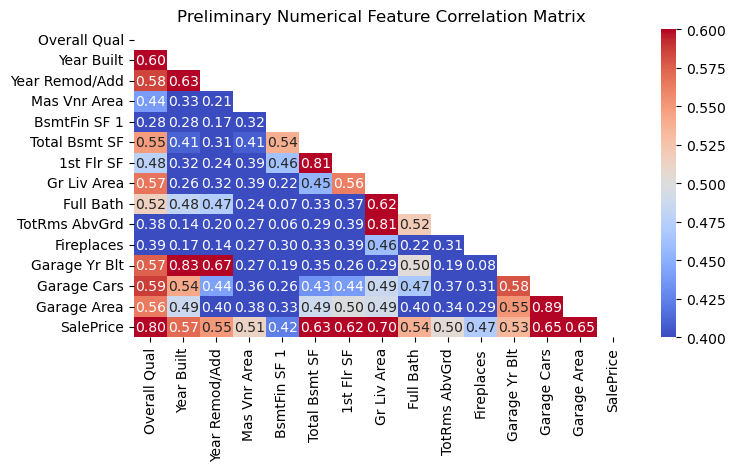

In [12]:
# Plot the correlation map between features

# Show only bottom left of heatmap
# From Lesson 1.07 - # This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(train[prelim_features].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,4))
plt.title('Preliminary Numerical Feature Correlation Matrix')
sns.heatmap(train[prelim_features].corr(),
            annot = True, 
            vmin = 0.4, vmax = .60, # Seeting these limits quickly establishes which corelations are above 0.6 and below 0.4.  Again, negative correlations are all greater than -0.4 and are ignored
            fmt='.2f', # Source for "fmt='.2f'":  https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
            cmap = 'coolwarm', 
            mask = mask);

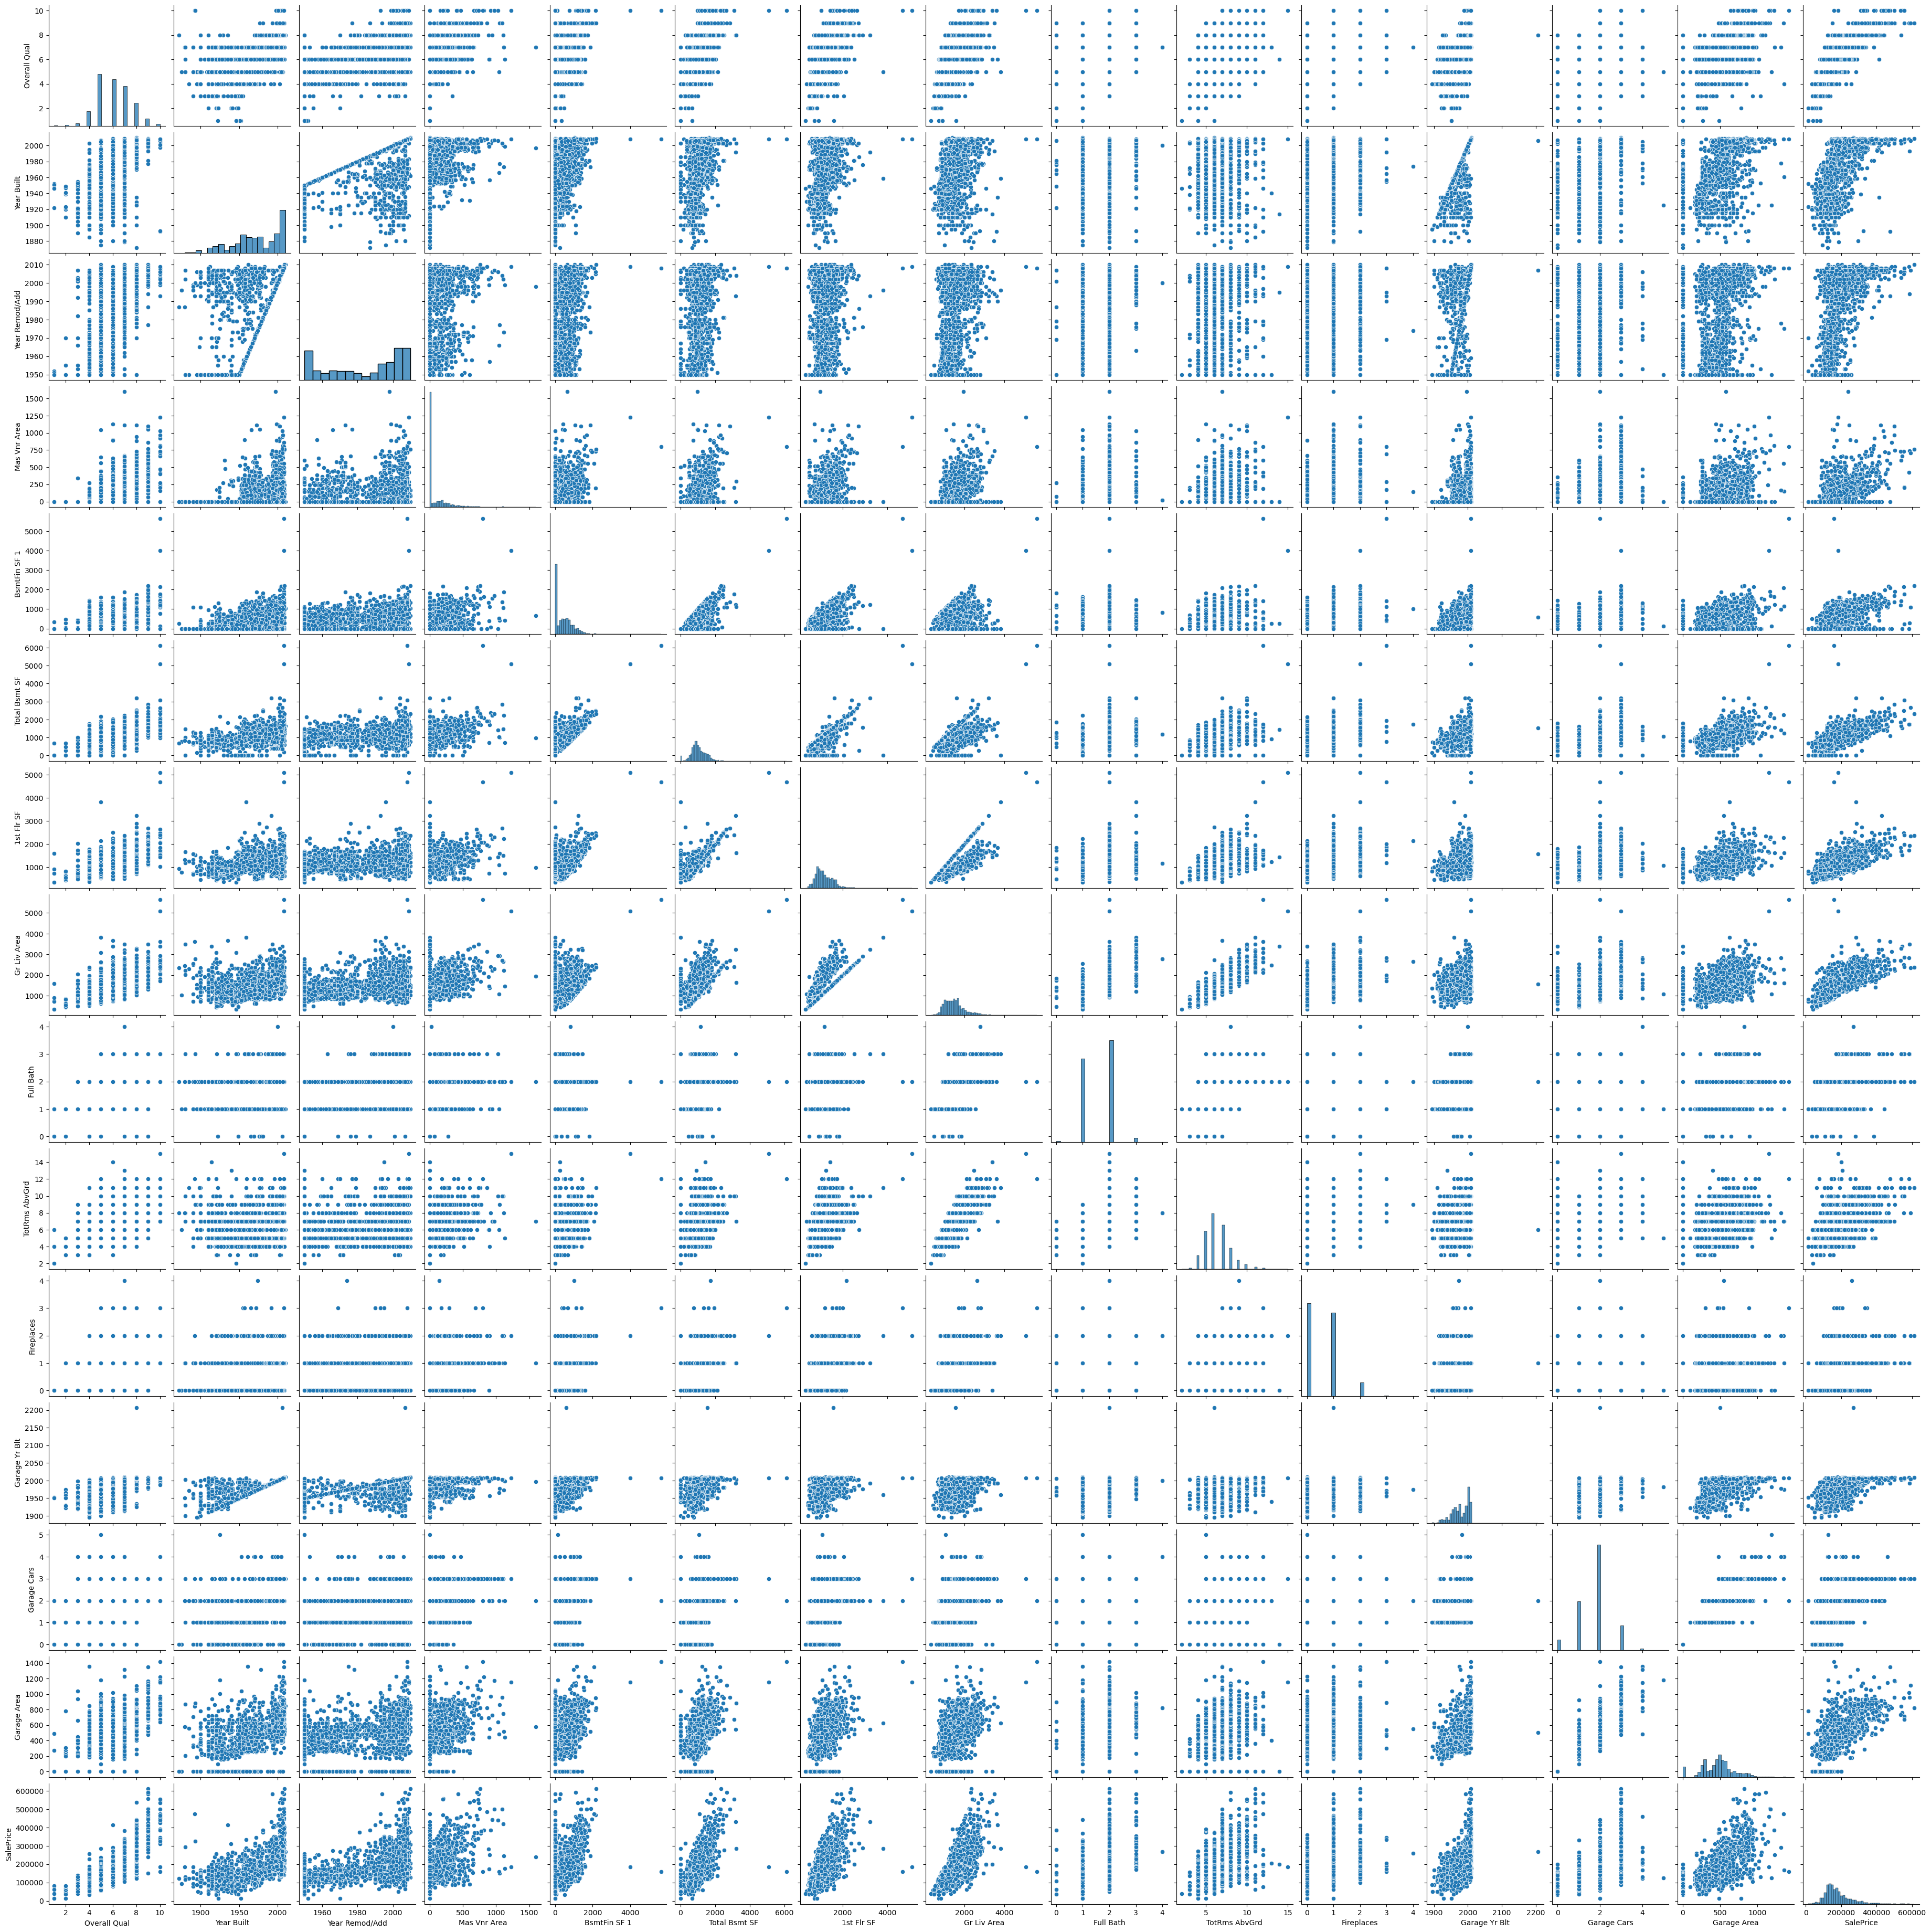

In [13]:
# Create a pair plot to get a high-level plot view of all features in 'prelim_features'
sns.pairplot(train[prelim_features])

#### Observation:  Given the strong numerical and visual correlations observed above, creating a linear regression model to predict home values should be attainable with the data provided.

In [14]:
# Use set subtraction to return a list of all numerical features (taken from the correlation plot) which are NOT included in preliminary features.
# This list is only to create a visual reference for the remaining features to be dispositioned to be included in the model
set(train.corr().index) - set(prelim_features)

{'2nd Flr SF',
 '3Ssn Porch',
 'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Unf SF',
 'BsmtFin SF 2',
 'Enclosed Porch',
 'Half Bath',
 'Id',
 'Kitchen AbvGr',
 'Lot Area',
 'Low Qual Fin SF',
 'Misc Val',
 'Open Porch SF',
 'Overall Cond',
 'PID',
 'Pool Area',
 'Screen Porch',
 'Wood Deck SF',
 'Yr Sold'}

#### 2.2.1.1 - Numerical Feature Selection

Check for colinearity:  Examine correlations above 0.6 ("strong" correlations) above between features that are not the target.  Where features are colinear, choose the better one to use in the model and list the rationale.
1. Year Built vs. Overall Qual:  Newer house, better quality.
    * USE QUALITY - Quality seems to track better with SalePrice
2. Year Built vs. Year Remod/Add:  Makes sense that these would correlate as they may be the same number since Year Remod/Add defaults ot the build date if there was nothing added or remodeled
    * USE YEAR REMOD/ADD - Lower correlation with garage built (though still high)
3. Year Built vs. Garage Yr Built:  High correlation would suggest that many times, the garage is built with the house
    * DON'T USE GARAGE YR BUILT - Garage Yr Built may not be a very useful feature in this model.  Garage Cars is a better feature to use if you want to limit the number of garage features since it correlates better with sale price
4. Year Remod/Add vs. Garage Yr Built:  Lower but still strong correlation between the remodel data and the garage build.  Would suggest that many house additions were actually garages
    * USE YEAR REMOD/ADD - Stated previously
5. 1st Flr SF vs. Total Basement SF:  It makes sense that the first floor and basement have approximately the same sqaure footage.  Basement square footage correlates a bit better with sale price.
    * USE Total Basement SF:  Later, Gr Liv Area is a bette measure of home sqaure footage.  Basement is not included in this measure and will act as a unique basement feature.
6. GR Liv Area vs. Full Bath:  It makes sense that these would correlate.  Not clear on whether one or the other should be used
    * TBD
7. GR Liv Area vs. TotRms AbvGrd:  Very strong correlation, preference would be to keep square footage, especially since it correlates better with sale price (0.7 vs 0.5 correlation coefficients)
    * Use Gr Liv Area
8. Garage Area and Garage Cars:  More cars, more area.
    * Use Garage Area because correaltion with sale price is equivalent to that of the number of garage cars but keeps with the square footage theme above
    
Review the remaining features which have correlations magnitudes above 0.4 relative to the target variable, sale price.
* BsmtFin SF 1 - DO NOT USE:  This is only for a type 1 basement, and seems redundnat to total basement square footage (conceptually if no numerically)
* Full Bath - DO NOT USE:  This is too strongly correlated with above grade sqaure footage which is conceptually a better metric
* Mas Vnr Area - MAYBE USE:  Masonry could be indicative of a more expensive house.  Compare against other features later
* Fireplaces - MAYBE USE:  Fireplaces could be indicative of a more expensive house.  Compare against other features later

List of numerical features to be considered:
* Overall Quality
* Year Remod/Add
* Total Basement SF
* Gr Liv Area
* Garage Area
* Mas Vnr Area (MAYBE)
* Fireplaces (MAYBE)


DO NOT USE:
* Garage Yr Blt
* 1st Flr SF
* Garage Cars
* TotRms AbvGrd
* Year Built
* BsmtFin SF 1
* Full Bath

Remaining Numerical Variables:


* 2nd Flr SF - DO NOT USE - total SF is a better metric
* 3Ssn Porch - MAYBE
* Bedroom AbvGr - MAYBE - could be redundant with Total SF
* Bsmt Full Bath - MAYBE - not all basements have bathrooms
* Bsmt Half Bath - MAYBE - not all basements have bathrooms
* Bsmt Unf SF - DO NOT USE - Redundant with total basement SF
* BsmtFin SF 2 - DO NOT USE - Only for a type 2 basement and redundant with total basement SF
* Enclosed Porch - MAYBE
* Half Bath - DO NOT USE - Same reason as full bathrooms above
* Id - DO NOT USE - this is just an identifier for each house and is not a real feature
* Kitchen AbvGr - MAYBE
* Lot Area - USE THIS! - this should indicate how much land is attached to said home
* Low Qual Fin SF - Maybe?  This could be a modifier or possibly a feature could be made from this (like a percentage of the total square feet)
* Misc Val - MAYBE - But, likely not a good candidate of a first pass model
* Open Porch SF - MAYBE
* Overall Cond - MAYBE - Seems redundant with overall quality
* PID -  DO NOT USE - this is just an identifier for each house and is not a real feature
* Pool Area - USE THIS! - Everybody loves a pool!
* Screen Porch - MAYBE
* Wood Deck SF - USE THIS! - Decks should add value
* Yr Sold - USE THIS!  Might be needed for economic conditions given the timeframe being right around the housing bubble.

#### NOTE:  These are not final dispositions (but rather candidates) as the categorical variables still need to be examined in subsequent sections.

### 2.2.2 - EDA - Examine Numerical Data and Basic Statistics

For the numeircal variables listed above to be considered (or maybe be considered), basic statistical data will be gathered.

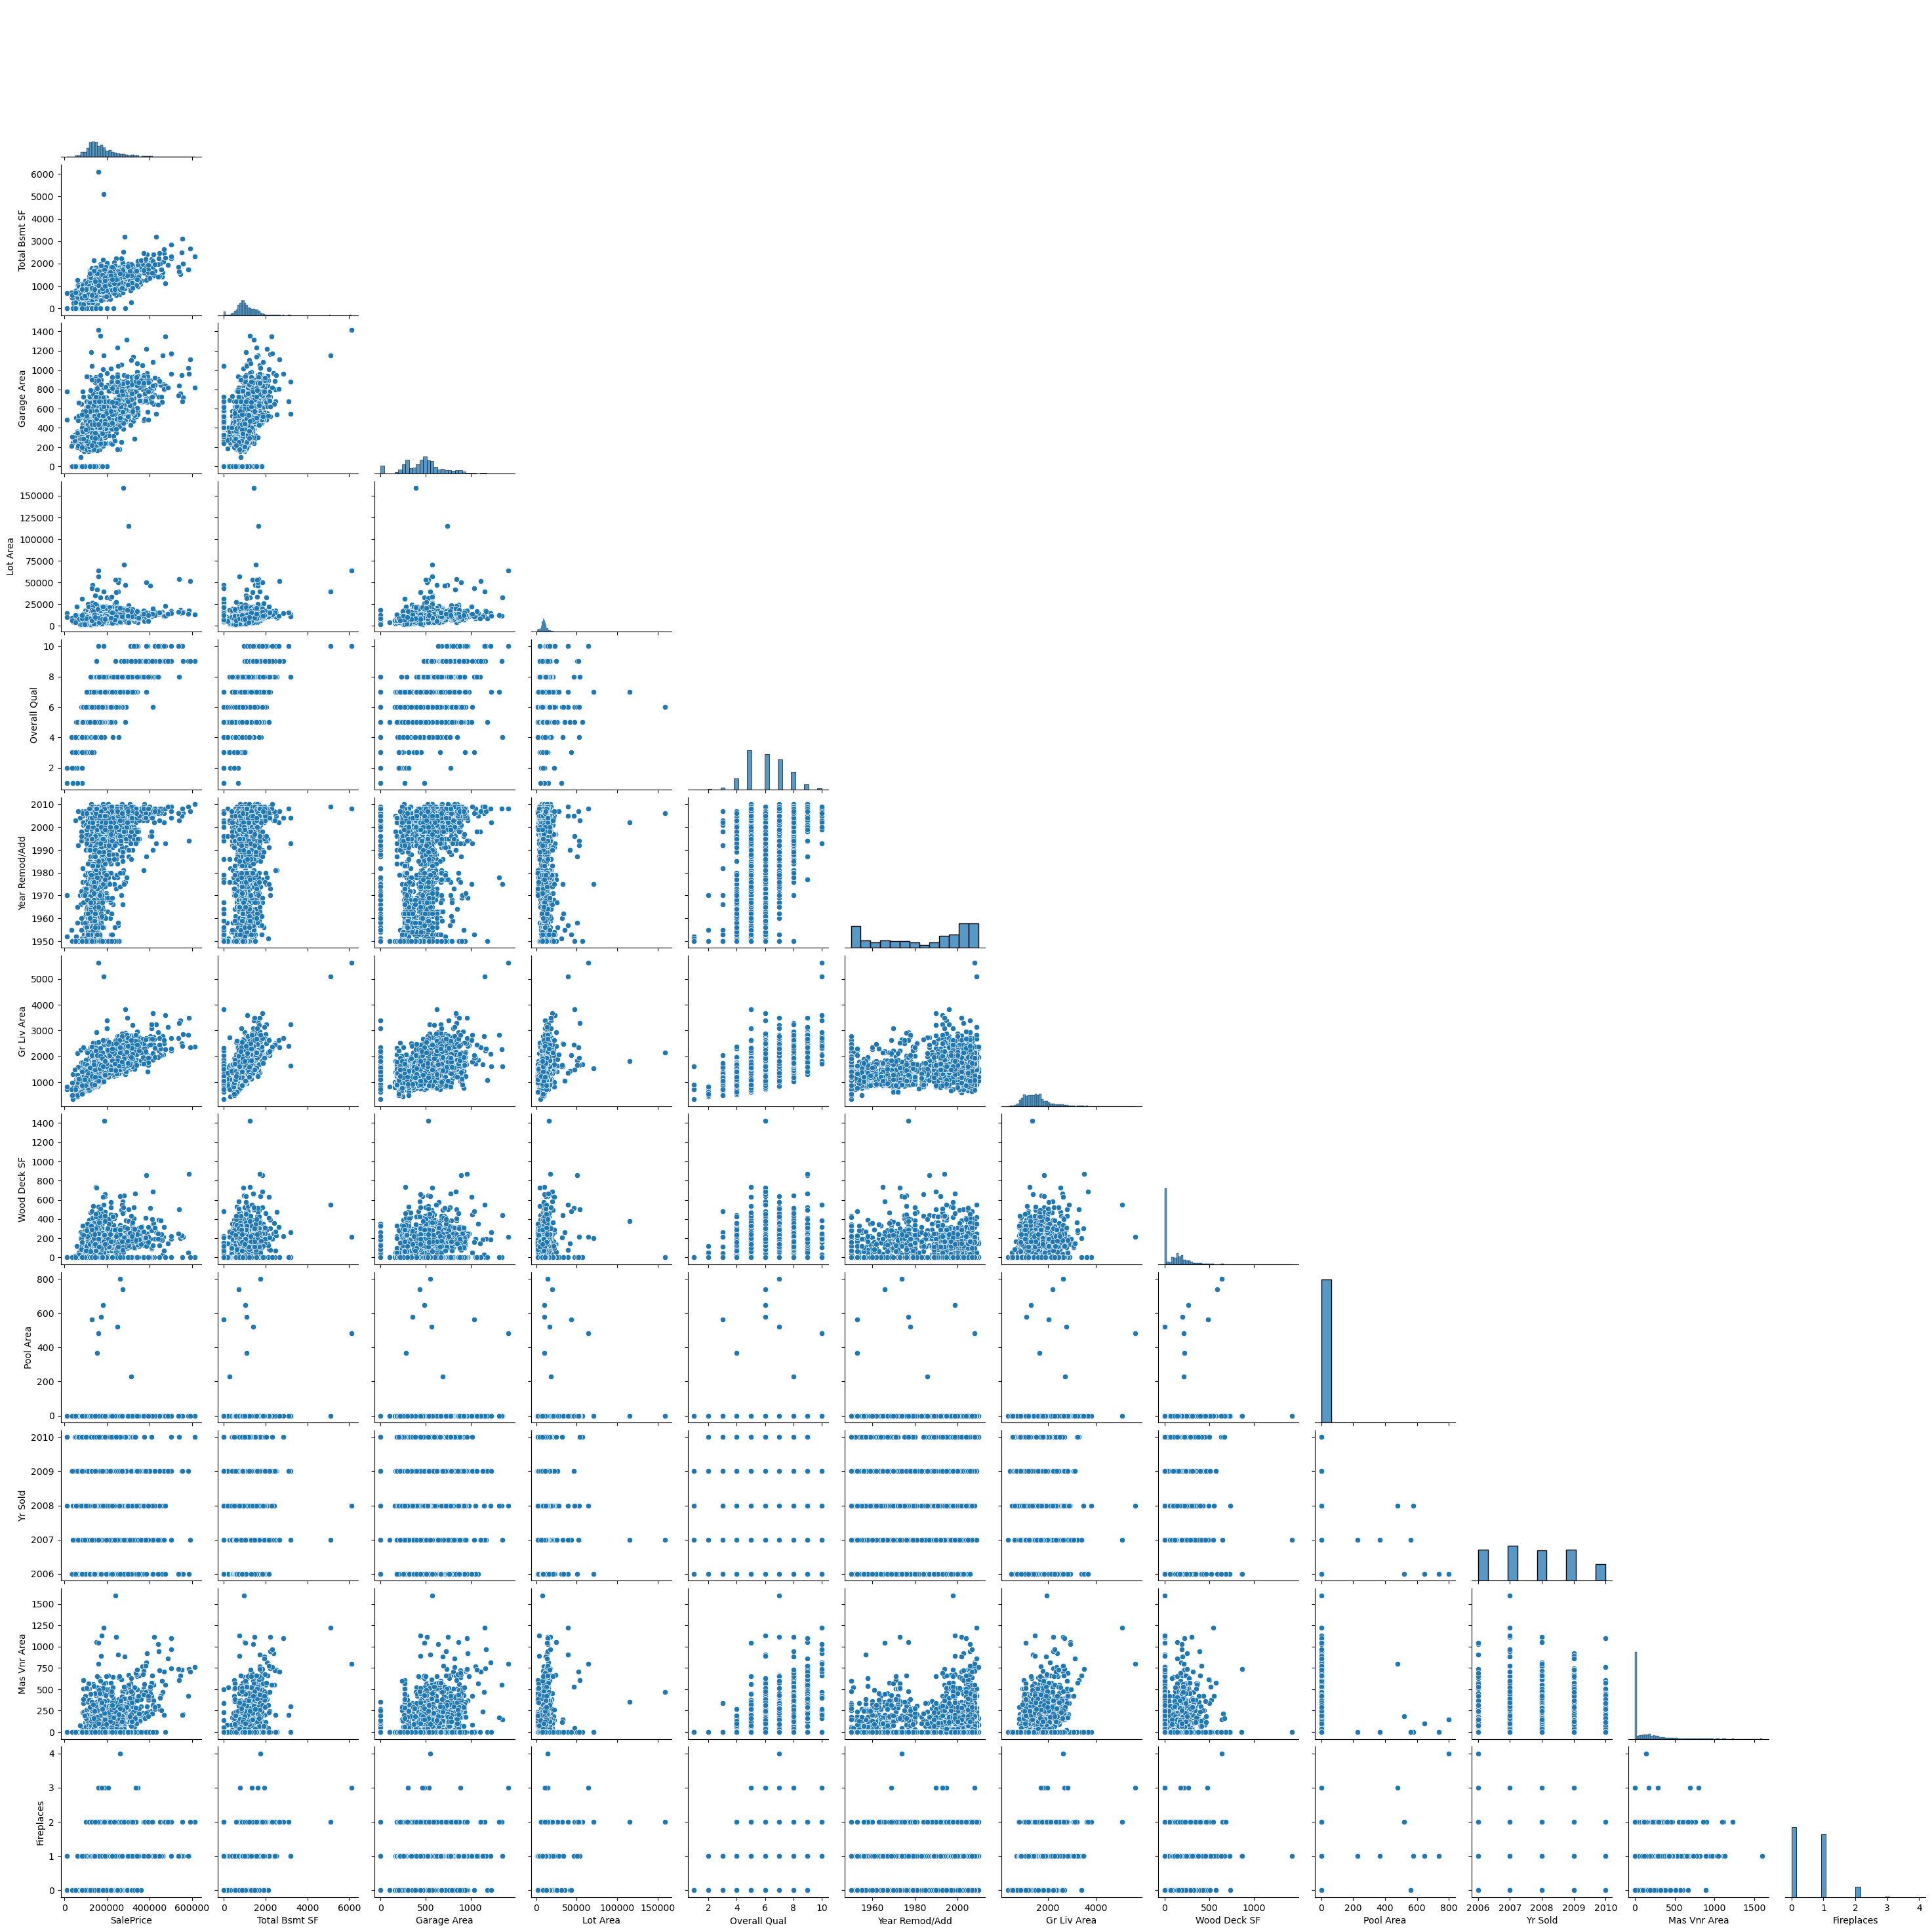

In [15]:
# From the list of numerical variables above, create a pairplot to visualize the correlations/relationships
sns.pairplot(train[['SalePrice',
                    'Total Bsmt SF',
                    'Garage Area',
                    'Lot Area',
                    'Overall Qual',
                    'Year Remod/Add',
                    'Gr Liv Area',
                    'Wood Deck SF',
                    'Pool Area',
                    'Yr Sold', 
                    'Mas Vnr Area',
                    'Fireplaces'
                   ]], corner=True)

In [16]:
# Use .describe to quickly get the basic stats

train[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual', 'Year Remod/Add',
       'Gr Liv Area', 'Wood Deck SF', 'Pool Area', 'Yr Sold', 'Mas Vnr Area', 'Fireplaces']].describe()

SalePrice  Total Bsmt SF  Garage Area       Lot Area  Overall Qual  \
count    2051.000000    2050.000000  2050.000000    2051.000000   2051.000000   
mean   181469.701609    1057.987805   473.671707   10065.208191      6.112140   
std     79258.659352     449.410704   215.934561    6742.488909      1.426271   
min     12789.000000       0.000000     0.000000    1300.000000      1.000000   
25%    129825.000000     793.000000   319.000000    7500.000000      5.000000   
50%    162500.000000     994.500000   480.000000    9430.000000      6.000000   
75%    214000.000000    1318.750000   576.000000   11513.500000      7.000000   
max    611657.000000    6110.000000  1418.000000  159000.000000     10.000000   

       Year Remod/Add  Gr Liv Area  Wood Deck SF    Pool Area      Yr Sold  \
count     2051.000000  2051.000000   2051.000000  2051.000000  2051.000000   
mean      1984.190151  1499.330083     93.833740     2.397855  2007.775719   
std         21.036250   500.447829    128.549416    37.782570     1.312014   
min       1950.000000   334.000000      0.000000     0.000000  2006.000000   
25%       1964.500000  1129.000000      0.000000     0.000000  2007.000000   
50%       1993.000000  1444.000000      0.000000     0.000000  2008.000000   
75%       2004.000000  1728.500000    168.000000     0.000000  2009.000000   
max       2010.000000  5642.000000   1424.000000   800.000000  2010.000000   

       Mas Vnr Area   Fireplaces  
count   2029.000000  2051.000000  
mean      99.695909     0.590931  
std      174.963129     0.638516  
min        0.000000     0.000000  
25%        0.000000     0.000000  
50%        0.000000     1.000000  
75%      161.000000     1.000000  
max     1600.000000     4.000000

In [17]:
# Examine the cheapest home in the data
train[train['SalePrice'] == 12789][['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual', 'Year Remod/Add',
       'Gr Liv Area', 'Wood Deck SF', 'Pool Area', 'Yr Sold', 'Mas Vnr Area', 'Fireplaces']]

SalePrice  Total Bsmt SF  Garage Area  Lot Area  Overall Qual  \
1628      12789          678.0        780.0      9656             2   

      Year Remod/Add  Gr Liv Area  Wood Deck SF  Pool Area  Yr Sold  \
1628            1970          832             0          0     2010   

      Mas Vnr Area  Fireplaces  
1628           0.0           1

#### Observations:
* Sale Prices Range between \\$12,789 and \\$611,657
    * The lowest price seems very low, and from the looks of it may be a typo.  This will be left as-is given that the best way to handle this is debatable
* Sales data is between 2006 and 2010 during which time a massive housing and financial crissis occurred.  This could also be a reason for sale price outliers depending the circumstances during or after this crisis
* All other numerical data explored appear to make sense, minimum values of 0 for things like basements and garages are completely reasonable if the house had neither.


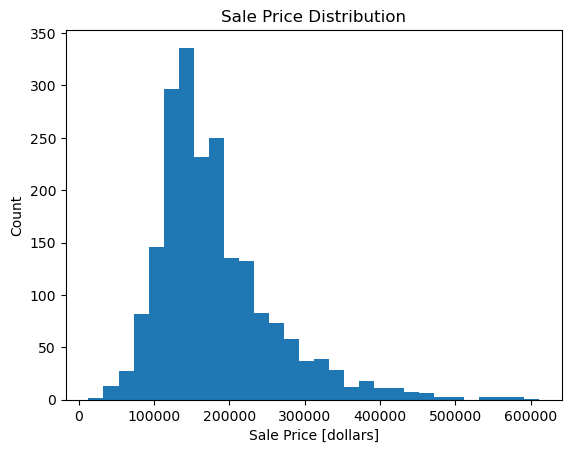

In [114]:
# Examine the target variable (sale price) distribution:
plt.hist(train['SalePrice'], bins = 30);
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price [dollars]')
plt.ylabel('Count')
plt.savefig('../images/saleprice_distr.png')

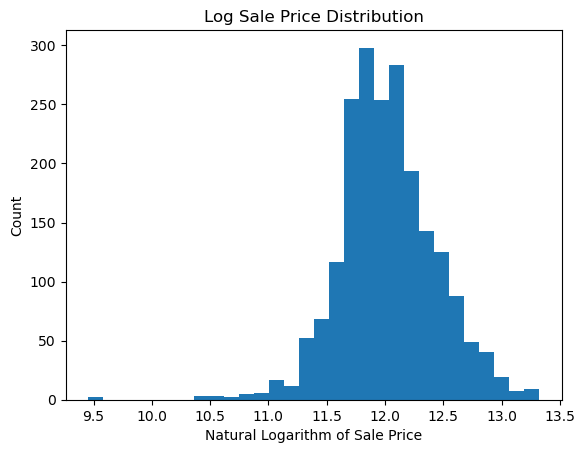

In [115]:
# Given the skewed distribution, check the log of the sale price:
#  Special thanks to Alanna Besaw for suggesting a strategy which atttempts to normalize the distribution with a log tranformation
plt.hist(np.log(train['SalePrice']), bins = 30);
plt.title('Log Sale Price Distribution')
plt.xlabel('Natural Logarithm of Sale Price')
plt.ylabel('Count')
plt.savefig('../images/saleprice_log_distr.png')

Above, it can be seen that a log transformation of the sale price data does help to alleviate some of the right skew, but not all can be eliminated.

Note also that the very cheap home(s) is even further away from the distribution on the left.

### 2.2.3 Other Numerical Features
As stated previously, the goal of the holistic feature selection approach is to include something from each of the main home feature categories (kitchen, driveway, general, basement, garage, etc.).  This will be done as much as possible provided that too many features are not utilized.  These may even be selcted over features where correlations are proven to be higher, in keeping with the holistic approach.

Of the previously idnetified 'remaining numerical variables' the following will be used as they incorporate things like decks, pools, and other home value adders:
* 'Bedroom AbvGr',
* 'Wood Deck SF',
* 'Pool Area',
* 'Misc Val',
* 'Yr Sold',
* 'Neighborhood',
* 'Bldg Type',
* 'Exter Cond',
* 'Paved Drive'

### 2.2.4 - Categorical Variable Selection Discussion and Encoding

The remaining features to be considered are categorical in nature.

Of those, many were considered to be included in this model, however, as most will need to be one-hot encoded, the number of feauters will dramatically increase as some of these features have a high number of unique values.  

The target is to keep the total number of featuers at or below the square root of the total number of samples.  With a total number of samples at 2051, this will have our maximum number of features at 45.

Since all features cannot efficiently be one-hot encoded and correlated to the sale price, practical/intuitive decisions were made on the relevance of each catgorical variable.  One thing that was considered is general category of each variable which specifically refers to which part of the 'home' the variable concerns such as the kitchen, deck, basement, garage, general home, and even some time based variables.  Part of the selection philosophy was to include variables from as many of these categories as possible in order to have a holistic representation of all aspects which could influence the home value (and therefore the sale price).  Even from this, some categories had to be excluded in favor of features which are reasonably perceived to be of higher relevance to the home value.

The categories below were selected as initial model features and are broken down into which are one-hot encoded, and which are number encoded.  These will be encoded in a subsequent section.

Selected features which must be one-hot encoded:
* 'Utilities'
* 'Neighborhood'
* 'Bldg Type'
* 'House Style'
* 'Paved Drive'

Features representing a spectrum of quality or condition which could be encoded as numbers with higher numbers representing higher quality:
* 'Exter Cond'

The follwoing features would have been selected, however, with all above features, the 45 feature limit will be exceeded unless these are excluded.
* 'Heating QC'
* 'Kitchen Qual'

### 2.2.5 - Initial Data Dictionary and Feature Selection Information

This table combines the selection of numerical and catgeorical variables.  These were selected largely via a qualitative evaluation of the perceived importance of each feature, *though the features previously determined to have the very strongest correlations with sale price have been preserved.* Again, features were selected or removed to keep the total feature count within reasonable limits.

Extended feature count represents the final feature count after encoding (one-hot or other)


| Feature          | dtype   | Ext. Ft. Count | Codebook / Data Dictionary:                                                            | Category | Rationale            |
|------------------|---------|----------------|----------------------------------------------------------------------------------------|----------|----------------------|
|  'Total Bsmt SF' | float64 | 1              | TotalBsmtSF: Total square feet of basement area                                        | Basement | High Corr.           |
|  'Garage Area'   | float64 | 1              | GarageArea: Size of garage in square feet                                              | Garage   | High Corr.           |
|  'Lot Area'      | int64   | 1              | LotArea: Lot size in square feet                                                       | Lot      | Practical Importance |
|  'Overall Qual'  | int64   | 1              | OverallQual: Overall material and finish quality                                       | General  | High Corr.           |
| 'Year Remod/Add' | int64   | 1              | YearRemodAdd: Remodel date (same as construction date if no remodeling or   additions) | Time     | Mod Corr             |
| 'Gr Liv Area'    | int64   | 1              | GrLivArea: Above grade (ground) living area square feet                                | General  | High Corr.           |
|  'Bedroom AbvGr' | int64   | 1              | Bedroom: Number of bedrooms above basement level                                       | Bedroom  | Practical Importance |
|  'Wood Deck SF'  | int64   | 1              | WoodDeckSF: Wood deck area in square feet                                              | Deck     | Practical Importance |
|'Pool Area'       | int64   | 1              | PoolArea: Pool area in square feet                                                     | Pool     | Practical Importance |
|  'Misc Val'      | int64   | 1              | MiscVal: $Value of miscellaneous feature                                               | Other    | Direct Value Measure |
|  'Yr Sold'       | int64   | 1              | YrSold: Year Sold                                                                      | Time     | Time Sensitivity     |
| 'Neighborhood'   | object  | 27             | Neighborhood: Physical locations within Ames city limits                               | Location | Practical Importance |
|  'Bldg Type'     | object  | 4              | BldgType: Type of dwelling                                                             | General  | Practical Importance |
| 'Exter Cond'     | object  | 1              | ExterCond: Present condition of the material on the exterior                           | Exterior | Practical Importance |
|  'Paved Drive'   | object  | 2              | PavedDrive: Paved driveway                                                             | Driveway | Practical Importance |

Codebook / Data Dictionary Entries Taken Directly from the Kaggle Competition Site: [link](https://www.kaggle.com/competitions/dsir-320-project-2-regression-challenge/data)

Note the high number of neighborhood columns.  A source listed in Appendix A suggests that the neighborhood is an important determinant of home value.  Thus, efforts were made to incorporate these features.



### 2.2.6 - Creating the Initial Model Dataframe

Prior to encoding, a dataframe with all features data must be made.

In [20]:
# Create a list of the desired features

features_init = ['SalePrice',
                 'Total Bsmt SF',
                 'Garage Area',
                 'Lot Area',
                 'Overall Qual',
                 'Year Remod/Add',
                 'Gr Liv Area',
                 'Bedroom AbvGr',
                 'Wood Deck SF',
                 'Pool Area',
                 'Misc Val',
                 'Yr Sold',
                 'Neighborhood',
                 'Bldg Type',
                 'Exter Cond',
                 'Paved Drive']

In [21]:
# Creating the dataframe based on the feature list
init_data = train[features_init]

In [22]:
init_data.head()

SalePrice  Total Bsmt SF  Garage Area  Lot Area  Overall Qual  \
0     130500          725.0        475.0     13517             6   
1     220000          913.0        559.0     11492             7   
2     109000         1057.0        246.0      7922             5   
3     174000          384.0        400.0      9802             5   
4     138500          676.0        484.0     14235             6   

   Year Remod/Add  Gr Liv Area  Bedroom AbvGr  Wood Deck SF  Pool Area  \
0            2005         1479              3             0          0   
1            1997         2122              4             0          0   
2            2007         1057              3             0          0   
3            2007         1444              3           100          0   
4            1993         1445              3             0          0   

   Misc Val  Yr Sold Neighborhood Bldg Type Exter Cond Paved Drive  
0         0     2010       Sawyer      1Fam         TA           Y  
1         0     2009      SawyerW      1Fam         TA           Y  
2         0     2010        NAmes      1Fam         Gd           Y  
3         0     2010       Timber      1Fam         TA           Y  
4         0     2010      SawyerW      1Fam         TA           N

#### 2.2.6.1 - One Hot Encoding Variables

In [23]:
# Print the unique values for each category and make sure that the data look correct
for i in ['Neighborhood', 'Bldg Type', 'Paved Drive']:
    print(init_data[i].unique())

['Sawyer' 'SawyerW' 'NAmes' 'Timber' 'Edwards' 'OldTown' 'BrDale'
 'CollgCr' 'Somerst' 'Mitchel' 'StoneBr' 'NridgHt' 'Gilbert' 'Crawfor'
 'IDOTRR' 'NWAmes' 'Veenker' 'MeadowV' 'SWISU' 'NoRidge' 'ClearCr'
 'Blmngtn' 'BrkSide' 'NPkVill' 'Blueste' 'GrnHill' 'Greens' 'Landmrk']
['1Fam' 'TwnhsE' 'Twnhs' '2fmCon' 'Duplex']
['Y' 'N' 'P']


In [24]:
# One hot encode categorical variables which are not going to be encoded as numbers.
# Note, after some checking, drop_first appears to drop the desired columns for Bloomington, Single Family Homes, and Unpaved Driveways
init_data = pd.get_dummies(columns=['Neighborhood', 'Bldg Type', 'Paved Drive'],
               data = init_data,
              drop_first= True
              )

In [25]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2050 non-null   float64
 2   Garage Area           2050 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   object 
 13  Neighborhood_Blueste  2051 non-null   uint8  
 14  Neighborhood_BrDale   2051 non-null   uint8  
 15  Neighborhood_BrkSide 

#### 2.2.6.2 - Number Encoding Variables
Again, as the categories of each of the following variables can establish a spectrum of quality or condition, they will be encoded as discrete numerical variables.  This will also help to keep the feature size lower.

In [26]:
# Check the exact names of values for exterior condition:
init_data['Exter Cond'].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [27]:
# Encode values 1 through 5 based on the condition into the 'Exter Cond' column, 5 being Excellent and 1 being Poor
init_data['Exter Cond'] = [5 if i == 'Ex' else 4 if i == 'Gd' else 3 if i == 'TA' else 2 if i == 'Fa' else 1 for i in init_data['Exter Cond']]

In [28]:
# Check that all columns are a number of some sort:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2050 non-null   float64
 2   Garage Area           2050 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   int64  
 13  Neighborhood_Blueste  2051 non-null   uint8  
 14  Neighborhood_BrDale   2051 non-null   uint8  
 15  Neighborhood_BrkSide 

In [29]:
# There are two null values that should be investigated:
init_data[(pd.isna(init_data['Total Bsmt SF']) == True) | (pd.isna(init_data['Garage Area']) == True) ]

SalePrice  Total Bsmt SF  Garage Area  Lot Area  Overall Qual  \
1327      79000            NaN        280.0      5940             4   
1712     150909          859.0          NaN      9060             5   

      Year Remod/Add  Gr Liv Area  Bedroom AbvGr  Wood Deck SF  Pool Area  \
1327            1950          896              2             0          0   
1712            1999         1828              3           174          0   

      ...  Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  \
1327  ...                     0                     0                    0   
1712  ...                     0                     0                    0   

      Neighborhood_Veenker  Bldg Type_2fmCon  Bldg Type_Duplex  \
1327                     0                 0                 0   
1712                     0                 0                 0   

      Bldg Type_Twnhs  Bldg Type_TwnhsE  Paved Drive_P  Paved Drive_Y  
1327                0                 0              0              1  
1712                0                 0              0              1  

[2 rows x 46 columns]

##### NOTE:  It is likely safe to assume that if no value is collected for basement or garage square feet, then neither exist and would be 0.


In [30]:
# Fill the NaN valuse with 0
init_data.fillna(0, inplace=True)

#### 2.2.6.3 - Check for Colinearity in Initial Dataframe with Encoded Columns

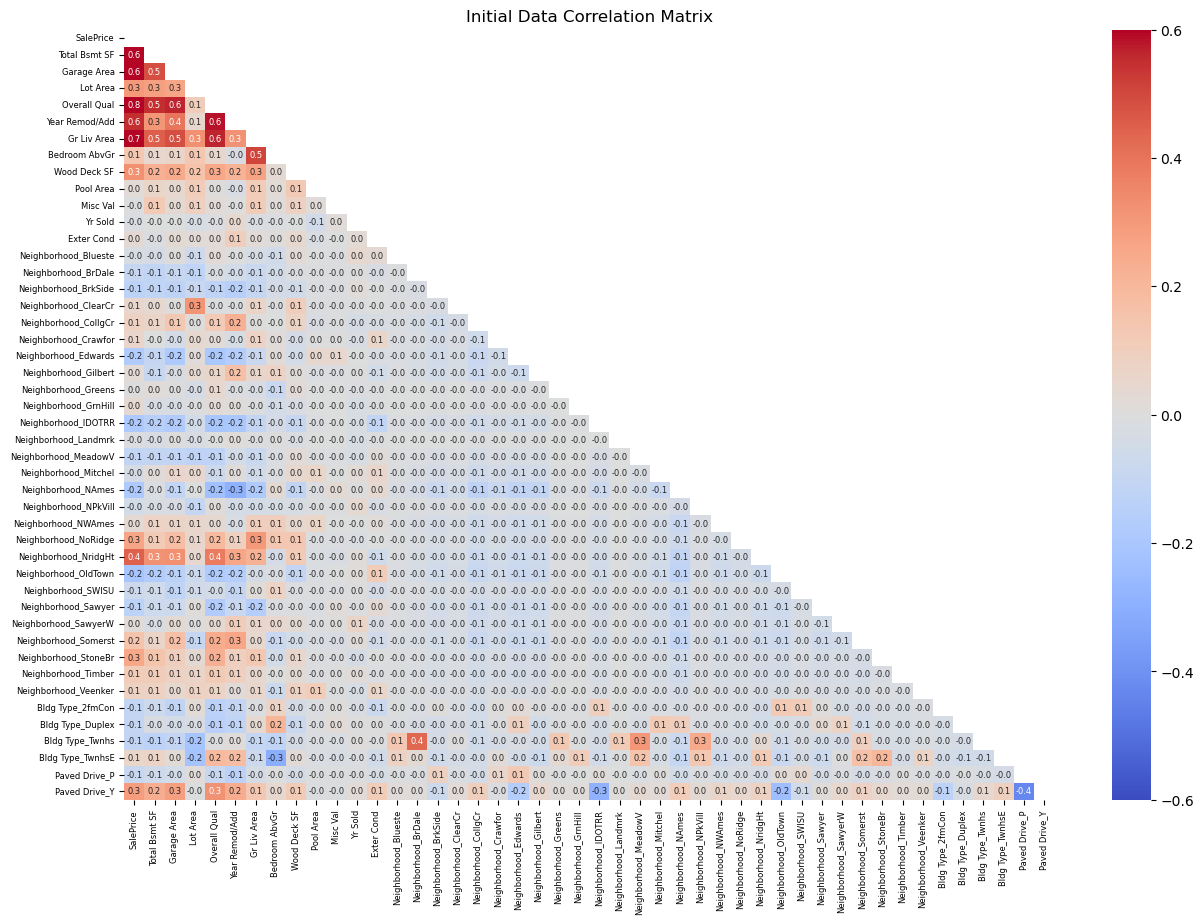

In [31]:
# Plot the correlation map between features

# Show only bottom left of heatmap
# From Lesson 1.07 - # This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html
#  'annot_kws={"size":8}' from:  https://stackoverflow.com/questions/33104322/auto-adjust-font-size-in-seaborn-heatmap
mask = np.zeros_like(init_data.corr())
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(15, 10))
plt.title('Initial Data Correlation Matrix')
plt.xticks(size = 6)
plt.yticks(size = 6)
sns.heatmap(init_data.corr(),
            annot = True, 
            vmin = -0.6, vmax = .6, # Again, this color scale helps to clearly show which correlations are the highest
            annot_kws={"size":6},
            fmt='.1f', 
            cmap = 'coolwarm', 
            mask = mask);

Above, no columns correlate with each other (save for the target) with a correlation coefficient above 0.6.  Thus, save for a few moderate correrlations, there is minimal colinearity.

# 3 - Initial Modeling

## 3.1 - Baseline (Null) Model - Mean Home Price
A simple way to gauge the effectiveness of any advanced modeling is to compare its performance to a very simple model with no advanced computational techniques.  This model is called the null or baseline model and will simply estimate the sale price of any home to be the mean of the sale prices in the 'init_data' dataset that was just created (after being plit into a training and testing dataset for comparison.  The root mean squaured error for this model will be calculated as an initial performance metric.  R-Squared values for this method would be at or close to zero as the null model as the R-sqaured calcualation includes the key freatures of the null model.

In [32]:
# Create train and test datasets!

# First, create X and y from the data above
X_init = init_data.drop(columns = 'SalePrice')
y_init = init_data['SalePrice']

# Run train test split:
X_init_train, X_init_test, y_init_train, y_init_test = train_test_split(X_init, y_init, random_state=0, test_size=0.3)

In [33]:
# Calculate the mean sale price (msp)
msp = y_init_train.mean()

# Calculate Root Mean Squared Error (RMSE) for the training and test datasets
rmse_train_null = (sum((y_init_train - msp)**2) / len(y_init_train))**.5
rmse_test_null = (sum((y_init_test - msp)**2) / len(y_init_test))**.5

# Calculate R-Sqaured for the 
r2_null_train = 1 - sum((y_init_train - msp)**2) / sum((y_init_train - y_init_train.mean())**2)
r2_null_test = 1 - sum((y_init_test - msp)**2) / sum((y_init_test - y_init_test.mean())**2)
r2_null_test

print(f'R-Squared for Training Data: {r2_null_train}')
print(f'R-Squared for Testing Data: {r2_null_test}')
print(f'RMSE for Training Data: {rmse_train_null}')
print(f'RMSE for Testing Data: {rmse_test_null}')

R-Squared for Training Data: 0.0
R-Squared for Testing Data: -0.0008224825454705709
RMSE for Training Data: 79420.10163725323
RMSE for Testing Data: 78826.35186766194


#### Observations:
* The R-squared values are aproximately 0, meaning that the model does not describe any of the variablity of the target variable.
* The RMSE values are also very high, themselves being equal to a significant percentage of the sale price of many of the homes
* This model is inadequate, and these numbers will serve as a benchmark upon which subsequent models must vastly improve

## 3.2 - Initial Linear Regression (ILR) Model

In [34]:
# Run initial LR model
lr_init = LinearRegression()

lr_init.fit(X_init_train, y_init_train)

LinearRegression()

In [35]:
# Get the R2 scores for the training and test datasets:
lr_init.score(X_init_train, y_init_train), lr_init.score(X_init_test, y_init_test)

(0.8621075729746097, 0.7975617855484634)

In [36]:
# Get the cross validation score for the training dataset
cross_val_score(lr_init, X_init_train, y_init_train)

array([0.83661378, 0.85716032, 0.79836608, 0.85400689, 0.76991106])

In [37]:
# Create predictions for the train and test datasets:
preds_train = lr_init.predict(X_init_train)
preds_test = lr_init.predict(X_init_test)

In [38]:
# Mean absolute error:
mean_absolute_error(y_init_train, preds_train), mean_absolute_error(y_init_test, preds_test)

(19786.240563288073, 20797.431808668072)

In [39]:
# Root mean sqaured error for training and test data:
mean_squared_error(y_init_train, preds_train, squared=False), mean_squared_error(y_init_test, preds_test, squared=False)

(29491.756965162534, 35451.87017486849)

In [40]:
# Create residual datasets
resid_init_train, resid_init_test = (y_init_train - preds_train), (y_init_test - preds_test)

In [41]:
# Get basic stats on the residuals
resid_init_train.describe()

count    1.435000e+03
mean     7.370266e-11
std      2.950204e+04
min     -2.343643e+05
25%     -1.408952e+04
50%     -6.514829e+02
75%      1.312520e+04
max      2.166684e+05
Name: SalePrice, dtype: float64

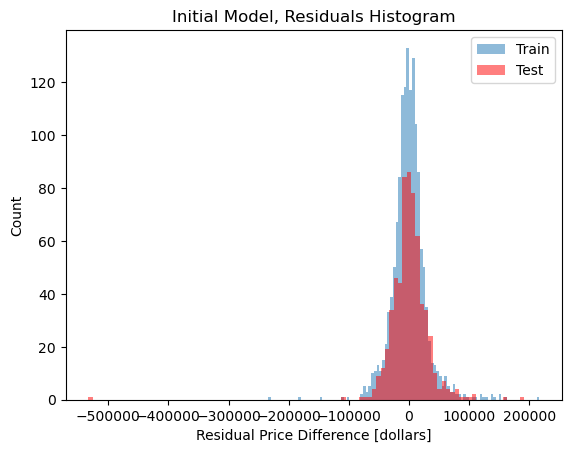

In [42]:
# PLot a histogram of the residuals
#  Source for legend:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
#  Source for legend labels:  https://stackoverflow.com/questions/59346731/no-handles-with-labels-found-to-put-in-legend
plt.hist(resid_init_train, bins = 100, alpha = 0.5, label = 'Train');
plt.hist(resid_init_test, color = 'red', bins = 100, alpha = 0.5, label='Test');
plt.legend()
plt.title('Initial Model, Residuals Histogram')
plt.xlabel('Residual Price Difference [dollars]')
plt.ylabel('Count');

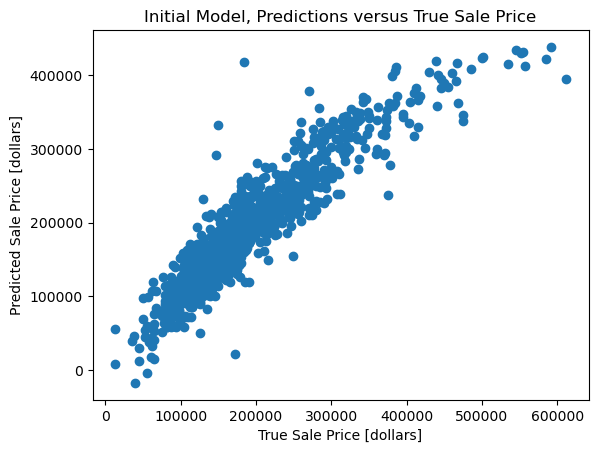

In [43]:
plt.scatter(y_init_train, preds_train)
plt.title('Initial Model, Predictions versus True Sale Price')
plt.xlabel('True Sale Price [dollars]')
plt.ylabel('Predicted Sale Price [dollars]');

#### Observations:
* The residual distributions are relatively normal
* In the lower plot, sale price predicitons tend to trail off, meaning that the model still has variability which is unaccounted for

# 4 - Linear Regression Model Refinement Through Additional Feature Engineering

A fucntion should be created to quickly run all code that is commonly run for a linear regression model.

This function will take in the X matrix and the target array, and will return a dataframe with all metrics associated with the Linear Regression fit.

In [44]:
# Create a funciton to make train test splits, fit the model, and all that stuff:

def split_fit_metric_frame(X, y, mod_name):
    # Create a train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # Create local Linear Regression instance:
    lr = LinearRegression()
    
    # Fit the function:
    lr.fit(X_train, y_train)
    
    # Create predictions:
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    # Get R2 train & test scores:
    r2_train = lr.score(X_train, y_train)
    r2_test = lr.score(X_test, y_test)
    
    # Get train & test RMSE:
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    
    # Get mean absolute error:
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    # Get cross validation scores and their mean
    cv_train = cross_val_score(lr, X_train, y_train, )
    cv_train_mean = cross_val_score(lr, X_train, y_train).mean()
    
    # Percentage within $30k
    within_30k = (abs(y_train - pred_train) < 30_000).mean() * 100
       
    # Sounce for numpy.around():  https://numpy.org/doc/stable/reference/generated/numpy.around.html
    items = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'mae_train', 'mae_test', 'Within $30k (%)', 'cv_train_mean', 'cv_train_1', 'cv_train_2', 'cv_train_3', 'cv_train_4', 'cv_train_5',]
    variables = [round(r2_train, 4), 
                 round(r2_test, 4), 
                 round(rmse_train), 
                 round(rmse_test), 
                 round(mae_train), 
                 round(mae_test),
                 round(within_30k, 4),
                 np.around(cv_train_mean, 4),
                 np.around(cv_train[0], 4),
                 np.around(cv_train[1], 4),
                 np.around(cv_train[2], 4),
                 np.around(cv_train[3], 4),
                 np.around(cv_train[4], 4),
                ]
    
    # Create global variables in the background so they can be called later:
    #  Source:  Special thanks to Alanna Besaw for help finding the globals() function!
    #  Source2:  https://www.geeksforgeeks.org/python-globals-function/
    globals()[f'X_train_{mod_name}'] = X_train
    globals()[f'X_test_{mod_name}'] = X_test
    globals()[f'y_train_{mod_name}'] = y_train
    globals()[f'y_test_{mod_name}'] = y_test    
    globals()[f'pred_train_{mod_name}'] = pred_train    
    globals()[f'pred_test_{mod_name}'] = pred_test    
    globals()[f'coefs_{mod_name}'] = pd.DataFrame(lr.coef_, index = X.columns, columns = ['Coefs'])
    
    
    # Return a dataframe with all the metrics above!
    return pd.DataFrame(variables, index = items, columns = [f'{mod_name}'])

    

In [45]:
# Test function on the model already made and compare results:
model_metrics = split_fit_metric_frame(X_init, y_init, 'ILR').copy()
model_metrics

ILR
R2_train             0.8621
R2_test              0.7976
RMSE_train       29492.0000
RMSE_test        35452.0000
mae_train        19786.0000
mae_test         20797.0000
Within $30k (%)     80.8362
cv_train_mean        0.8232
cv_train_1           0.8366
cv_train_2           0.8572
cv_train_3           0.7984
cv_train_4           0.8540
cv_train_5           0.7699

## 4.1 - ILR Modification 1 - Drop the Neighborhood Columns and Observe Effects

In [46]:
# Drop neighborhood columns (repeat all columns except those...):
data_1 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
       'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
       'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
       'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']]

In [47]:
X1 = data_1.drop(columns = 'SalePrice')
y1 = data_1['SalePrice']

In [48]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X1, y1, 'data_1'), left_index=True, right_index=True)
model_metrics

ILR      data_1
R2_train             0.8621      0.8269
R2_test              0.7976      0.7389
RMSE_train       29492.0000  33043.0000
RMSE_test        35452.0000  40265.0000
mae_train        19786.0000  22611.0000
mae_test         20797.0000  23716.0000
Within $30k (%)     80.8362     75.4007
cv_train_mean        0.8232      0.7921
cv_train_1           0.8366      0.8321
cv_train_2           0.8572      0.8141
cv_train_3           0.7984      0.7651
cv_train_4           0.8540      0.8431
cv_train_5           0.7699      0.7060

#### Observations:
* Removing the neighborhood columns degraded the model performance

### 4.1.1 - ILR Modification 1 Coefficient Interpretations

In [49]:
coefs_data_1

Coefs
Total Bsmt SF        38.376935
Garage Area          41.995067
Lot Area              0.731598
Overall Qual      18678.092638
Year Remod/Add      434.867764
Gr Liv Area          57.814817
Bedroom AbvGr    -11218.681669
Wood Deck SF         22.661284
Pool Area             6.165861
Misc Val            -14.344356
Yr Sold            -408.814161
Exter Cond        -1950.450719
Bldg Type_2fmCon  -7293.285867
Bldg Type_Duplex  -6453.206095
Bldg Type_Twnhs  -23216.468362
Bldg Type_TwnhsE -16778.766808
Paved Drive_P     -7483.013630
Paved Drive_Y      4812.202271

* Total Bsmt SF - Holding all else constant, for each additional square foot of basement, the Sale Price increases by about $38.38

* Garage Area - Holding all else constant, for each additional square foot of garage space, the Sale Price increases by $42.00

* Lot Area - Holding all else constant, for each additional sqaure foot of lot area, the Sale Price increases by $0.73

* Overall Qual - Holding all else constant, for every additional quality point (1-10 scale) of the Overall Quality, the Sale Price increases by about $18,678.09

* Year Remod/add - Holding all else constant, for every one year later that the home was remodeled or added to, the Sale Price increases by about $434.87

* Gr Liv Area - Holding all else constant, for each additional square foot of graded living area, the Sale Price increases by about $57.81

* Bedroom AbvGr - Holding all else constant, for each additional above ground bedroom, the Sale Price decreases by $11,218.68

* Wood Deck SF - Holding all else constant, for each additional square foot of wood decking, the Sale Price increases by $22.66

* Pool Area - Holding all else constant, for each additional sqaure foot of pool area, the Sale Price increases by $6.17

* Misc Val - Holding all else constant, for each additional dollar of miscelaneously valued items included in the home, the Sale Price decreaes by $14.34

* Yr Sold - Holding all else constant, for each year later in the future that the home was sold, the Sale Price decreases by $408.81

* Exter Cond - Holding all else constant, for each additional quality point of the exterior (scale 1 to 5), the Sale Price decreases by $1950.45

* Bldg Type_2fmCon - Holding all else constant, relative to a single family detached home, a Two-family Conversion sells for $7,293.29 less

* Bldg Type_Duplex - Holding all else constant, relative to a single family detached home, a Duplex sells for $6,453.21 less

* Bldg Type_Twnhs - Holding all else constant, relative to a single family detached home, a Townhouse unit sells for $23,216.47 less

* Bldg Type_TwnhsE - Holding all else constant, relative to a single family detached home, a Townhouse end unit sells for $16,778.77 less

* Paved Drive_P - Holding all else constant, relative to a home with an unpaved driveway, a home with a partially paved driveway sells for $7,483.01 less

* Paved Drive_Y - Holding all else constant, relative to a home with an unpaved driveway, a home with a paved driveway sells for $4812.20 more

## 4.2 - ILR Modification 2 - Keep Best Correlated Neighborhood Features

<AxesSubplot:>

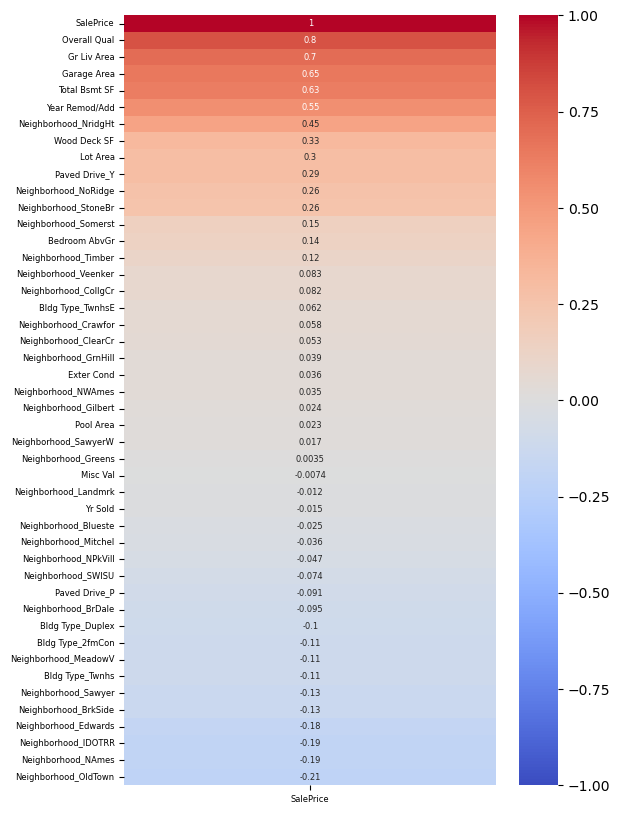

In [50]:
# Create a heatmap showing the correlations of each of the features in hte original dataset (init_data) against the sales price:
plt.figure(figsize=(6,10))
plt.xticks(size = 6)
plt.yticks(size = 6)          
sns.heatmap(init_data.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False),
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws={"size":6},
            cmap = 'coolwarm'
           )

In [51]:
# Output a list of features where the corraltion magnitude is greater than 0.2:
init_data.corr()['SalePrice'][(init_data.corr()['SalePrice'] >= 0.15) | (init_data.corr()['SalePrice'] <= -0.15)].index

Index(['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Wood Deck SF', 'Neighborhood_Edwards',
       'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Paved Drive_Y'],
      dtype='object')

Above:  Only eight neighborhoods have corraltions with the sale price with magnitudes greater than 0.15.  These will be added back into the model below

In [52]:
data_2 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
                    'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
                    'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
                    'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
                    'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
                    'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']]

In [53]:
X2 = data_2.drop(columns = 'SalePrice')
y2 = data_2['SalePrice']

In [54]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X2, y2, 'data_2'), left_index=True, right_index=True)
model_metrics

ILR      data_1      data_2
R2_train             0.8621      0.8269      0.8556
R2_test              0.7976      0.7389      0.7856
RMSE_train       29492.0000  33043.0000  30177.0000
RMSE_test        35452.0000  40265.0000  36486.0000
mae_train        19786.0000  22611.0000  20319.0000
mae_test         20797.0000  23716.0000  21498.0000
Within $30k (%)     80.8362     75.4007     79.6516
cv_train_mean        0.8232      0.7921      0.8214
cv_train_1           0.8366      0.8321      0.8385
cv_train_2           0.8572      0.8141      0.8529
cv_train_3           0.7984      0.7651      0.8056
cv_train_4           0.8540      0.8431      0.8490
cv_train_5           0.7699      0.7060      0.7608

Observations:
* Adding back in the eight neighborhoods above has recovered much of the performance that was lost by removing all neighborhoods
* While more could be added back in to increase performance, the feature count may be best left to find other more impactful features

## 4.3 - ILR Modification 3 - Keep Best Correlated Neighborhood Features, Add Other Home Features

In [55]:
data_3 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
                    'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
                    'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
                    'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
                    'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
                    'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']].copy()

data_3[['Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']] = train[['Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']].copy()

In [56]:
data_3.info()

data_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2051 non-null   float64
 2   Garage Area           2051 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   int64  
 13  Neighborhood_Edwards  2051 non-null   uint8  
 14  Neighborhood_IDOTRR   2051 non-null   uint8  
 15  Neighborhood_NAmes   

SalePrice  Total Bsmt SF  Garage Area  Lot Area  Overall Qual  \
0     130500          725.0        475.0     13517             6   
1     220000          913.0        559.0     11492             7   
2     109000         1057.0        246.0      7922             5   
3     174000          384.0        400.0      9802             5   
4     138500          676.0        484.0     14235             6   

   Year Remod/Add  Gr Liv Area  Bedroom AbvGr  Wood Deck SF  Pool Area  ...  \
0            2005         1479              3             0          0  ...   
1            1997         2122              4             0          0  ...   
2            2007         1057              3             0          0  ...   
3            2007         1444              3           100          0  ...   
4            1993         1445              3             0          0  ...   

   Neighborhood_StoneBr  Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  \
0                     0                 0                 0                0   
1                     0                 0                 0                0   
2                     0                 0                 0                0   
3                     0                 0                 0                0   
4                     0                 0                 0                0   

   Bldg Type_TwnhsE  Paved Drive_P  Paved Drive_Y  Mas Vnr Area  Fireplaces  \
0                 0              0              1         289.0           0   
1                 0              0              1         132.0           1   
2                 0              0              1           0.0           0   
3                 0              0              1           0.0           0   
4                 0              0              0           0.0           0   

   BsmtFin SF 1  
0         533.0  
1         637.0  
2         731.0  
3           0.0  
4           0.0  

[5 rows x 30 columns]

In [57]:
# There are a few samples with have null values for 'Mas Vnr Area' and 'BsmtFin SF 1'.  These can likely be iumputed with zeros.
#  It's not a bad assumption that null values for masonry and finished basements would indicate that neither exist in the home, and the square footage for each is 0.
data_3.fillna(0, inplace=True)
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2051 non-null   float64
 2   Garage Area           2051 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   int64  
 13  Neighborhood_Edwards  2051 non-null   uint8  
 14  Neighborhood_IDOTRR   2051 non-null   uint8  
 15  Neighborhood_NAmes   

In [58]:
X3 = data_3.drop(columns = 'SalePrice')
y3 = data_3['SalePrice']

In [59]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X3, y3, 'data_3'), left_index=True, right_index=True)
model_metrics

ILR      data_1      data_2      data_3
R2_train             0.8621      0.8269      0.8556      0.8743
R2_test              0.7976      0.7389      0.7856      0.7769
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000
mae_train        19786.0000  22611.0000  20319.0000  18457.0000
mae_test         20797.0000  23716.0000  21498.0000  20792.0000
Within $30k (%)     80.8362     75.4007     79.6516     82.7178
cv_train_mean        0.8232      0.7921      0.8214      0.8358
cv_train_1           0.8366      0.8321      0.8385      0.8737
cv_train_2           0.8572      0.8141      0.8529      0.8802
cv_train_3           0.7984      0.7651      0.8056      0.8111
cv_train_4           0.8540      0.8431      0.8490      0.8609
cv_train_5           0.7699      0.7060      0.7608      0.7532

#### Observations:
* The model performance has increased with the addition of just three features
* The perofrmance on the test data however is struggling in comparison to the ILR and ILR Mod 2

## 4.4 - New Linear Regression (NLR) Model 1 - Minimal Features

Features will be pared back signficantly to include only those identified in Section 2 with correlation magnitudes greater than 0.4.  Multicolinearity will be ignored as this is a prediciton model.

In [60]:
prelim_features

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')

In [61]:
data_4 = train[prelim_features].drop(columns = 'Garage Yr Blt')
data_4.head()
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    2051 non-null   int64  
 1   Year Built      2051 non-null   int64  
 2   Year Remod/Add  2051 non-null   int64  
 3   Mas Vnr Area    2029 non-null   float64
 4   BsmtFin SF 1    2050 non-null   float64
 5   Total Bsmt SF   2050 non-null   float64
 6   1st Flr SF      2051 non-null   int64  
 7   Gr Liv Area     2051 non-null   int64  
 8   Full Bath       2051 non-null   int64  
 9   TotRms AbvGrd   2051 non-null   int64  
 10  Fireplaces      2051 non-null   int64  
 11  Garage Cars     2050 non-null   float64
 12  Garage Area     2050 non-null   float64
 13  SalePrice       2051 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 224.5 KB


In [62]:
# Impute zeros for all null values using same logic as previously:  IF it's an NaN, assume the house does not have that feature and it's equal to 0.
data_4.fillna(0, inplace = True)
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    2051 non-null   int64  
 1   Year Built      2051 non-null   int64  
 2   Year Remod/Add  2051 non-null   int64  
 3   Mas Vnr Area    2051 non-null   float64
 4   BsmtFin SF 1    2051 non-null   float64
 5   Total Bsmt SF   2051 non-null   float64
 6   1st Flr SF      2051 non-null   int64  
 7   Gr Liv Area     2051 non-null   int64  
 8   Full Bath       2051 non-null   int64  
 9   TotRms AbvGrd   2051 non-null   int64  
 10  Fireplaces      2051 non-null   int64  
 11  Garage Cars     2051 non-null   float64
 12  Garage Area     2051 non-null   float64
 13  SalePrice       2051 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 224.5 KB


In [63]:
X4 = data_4.drop(columns = 'SalePrice')
y4 = data_4['SalePrice']

In [64]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X4, y4, 'data_4'), left_index=True, right_index=True)
model_metrics

ILR      data_1      data_2      data_3      data_4
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939

#### Observations:
* The above changes have decreased model performance to the second-lowest levels on the test data

## 4.5 - NLR1 with Polynomial Features

As the above model has the fewest number of features of any model yet, it will be a good model to explore the impact of polynomial features while still allowing some room for additional features to be incorporated.

In [65]:
poly = PolynomialFeatures(include_bias=False)

In [66]:
X4_poly = poly.fit_transform(X4)

In [67]:
X4_poly.shape

(2051, 104)

In [68]:
poly.get_feature_names_out(X4.columns)

array(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Overall Qual^2', 'Overall Qual Year Built',
       'Overall Qual Year Remod/Add', 'Overall Qual Mas Vnr Area',
       'Overall Qual BsmtFin SF 1', 'Overall Qual Total Bsmt SF',
       'Overall Qual 1st Flr SF', 'Overall Qual Gr Liv Area',
       'Overall Qual Full Bath', 'Overall Qual TotRms AbvGrd',
       'Overall Qual Fireplaces', 'Overall Qual Garage Cars',
       'Overall Qual Garage Area', 'Year Built^2',
       'Year Built Year Remod/Add', 'Year Built Mas Vnr Area',
       'Year Built BsmtFin SF 1', 'Year Built Total Bsmt SF',
       'Year Built 1st Flr SF', 'Year Built Gr Liv Area',
       'Year Built Full Bath', 'Year Built TotRms AbvGrd',
       'Year Built Fireplaces', 'Year Built Garage Cars',
       'Year Built Garage Area', 'Year Remod/Add^2',
   

In [69]:
X4_poly_corr = pd.DataFrame(X4_poly, columns=poly.get_feature_names_out(X4.columns))

In [70]:
X4_poly_corr['SalePrice'] = y4
X4_poly_corr.head()

Overall Qual  Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  \
0           6.0      1976.0          2005.0         289.0         533.0   
1           7.0      1996.0          1997.0         132.0         637.0   
2           5.0      1953.0          2007.0           0.0         731.0   
3           5.0      2006.0          2007.0           0.0           0.0   
4           6.0      1900.0          1993.0           0.0           0.0   

   Total Bsmt SF  1st Flr SF  Gr Liv Area  Full Bath  TotRms AbvGrd  ...  \
0          725.0       725.0       1479.0        2.0            6.0  ...   
1          913.0       913.0       2122.0        2.0            8.0  ...   
2         1057.0      1057.0       1057.0        1.0            5.0  ...   
3          384.0       744.0       1444.0        2.0            7.0  ...   
4          676.0       831.0       1445.0        2.0            6.0  ...   

   TotRms AbvGrd Fireplaces  TotRms AbvGrd Garage Cars  \
0                       0.0                       12.0   
1                       8.0                       16.0   
2                       0.0                        5.0   
3                       0.0                       14.0   
4                       0.0                       12.0   

   TotRms AbvGrd Garage Area  Fireplaces^2  Fireplaces Garage Cars  \
0                     2850.0           0.0                     0.0   
1                     4472.0           1.0                     2.0   
2                     1230.0           0.0                     0.0   
3                     2800.0           0.0                     0.0   
4                     2904.0           0.0                     0.0   

   Fireplaces Garage Area  Garage Cars^2  Garage Cars Garage Area  \
0                     0.0            4.0                    950.0   
1                   559.0            4.0                   1118.0   
2                     0.0            1.0                    246.0   
3                     0.0            4.0                    800.0   
4                     0.0            4.0                    968.0   

   Garage Area^2  SalePrice  
0       225625.0     130500  
1       312481.0     220000  
2        60516.0     109000  
3       160000.0     174000  
4       234256.0     138500  

[5 rows x 105 columns]

#### The feature correlations to sale price can now be calculated to find which features should pass on to the next model

In [71]:
# Find correlations where magnitude is greater than 0.6
X4_poly_corr.corr()[['SalePrice']][abs(X4_poly_corr.corr()['SalePrice']) >= 0.65].sort_values(by = "SalePrice")

SalePrice
Total Bsmt SF TotRms AbvGrd   0.650758
Year Remod/Add Garage Cars    0.656051
Year Remod/Add Garage Area    0.658191
Year Built Garage Cars        0.658688
Year Built Garage Area        0.661478
Garage Cars^2                 0.664522
Gr Liv Area Full Bath         0.682967
1st Flr SF Full Bath          0.686567
Garage Cars Garage Area       0.690596
Total Bsmt SF Garage Area     0.692389
Gr Liv Area                   0.697038
1st Flr SF Garage Area        0.705365
Year Remod/Add Gr Liv Area    0.707879
Total Bsmt SF Full Bath       0.712376
Full Bath Garage Cars         0.714775
Year Built Gr Liv Area        0.716450
TotRms AbvGrd Garage Area     0.719328
TotRms AbvGrd Garage Cars     0.720034
Full Bath Garage Area         0.738094
Gr Liv Area Garage Area       0.754659
Overall Qual Full Bath        0.756694
1st Flr SF Garage Cars        0.760121
Total Bsmt SF Garage Cars     0.767335
Overall Qual Total Bsmt SF    0.768630
Overall Qual 1st Flr SF       0.792151
Gr Liv Area Garage Cars       0.793274
Overall Qual TotRms AbvGrd    0.795420
Overall Qual                  0.800207
Overall Qual Year Remod/Add   0.804740
Overall Qual Year Built       0.806902
Overall Qual Garage Area      0.813247
Overall Qual Garage Cars      0.819935
Overall Qual^2                0.825539
Overall Qual Gr Liv Area      0.837152
SalePrice                     1.000000

#### Some trial and error has shown that choosing features with correlations above 0.65 produce decent results while keeping features within bounds and allowing room for other features to be reintegrated.

In [72]:
features_5 = X4_poly_corr.corr()[['SalePrice']][abs(X4_poly_corr.corr()['SalePrice']) >= 0.65].index

In [73]:
features_5

Index(['Overall Qual', 'Gr Liv Area', 'Overall Qual^2',
       'Overall Qual Year Built', 'Overall Qual Year Remod/Add',
       'Overall Qual Total Bsmt SF', 'Overall Qual 1st Flr SF',
       'Overall Qual Gr Liv Area', 'Overall Qual Full Bath',
       'Overall Qual TotRms AbvGrd', 'Overall Qual Garage Cars',
       'Overall Qual Garage Area', 'Year Built Gr Liv Area',
       'Year Built Garage Cars', 'Year Built Garage Area',
       'Year Remod/Add Gr Liv Area', 'Year Remod/Add Garage Cars',
       'Year Remod/Add Garage Area', 'Total Bsmt SF Full Bath',
       'Total Bsmt SF TotRms AbvGrd', 'Total Bsmt SF Garage Cars',
       'Total Bsmt SF Garage Area', '1st Flr SF Full Bath',
       '1st Flr SF Garage Cars', '1st Flr SF Garage Area',
       'Gr Liv Area Full Bath', 'Gr Liv Area Garage Cars',
       'Gr Liv Area Garage Area', 'Full Bath Garage Cars',
       'Full Bath Garage Area', 'TotRms AbvGrd Garage Cars',
       'TotRms AbvGrd Garage Area', 'Garage Cars^2', 'Garage Cars Garage 

In [74]:
data_5_poly = X4_poly_corr[features_5]
data_5_poly

Overall Qual  Gr Liv Area  Overall Qual^2  Overall Qual Year Built  \
0              6.0       1479.0            36.0                  11856.0   
1              7.0       2122.0            49.0                  13972.0   
2              5.0       1057.0            25.0                   9765.0   
3              5.0       1444.0            25.0                  10030.0   
4              6.0       1445.0            36.0                  11400.0   
...            ...          ...             ...                      ...   
2046           8.0       1728.0            64.0                  16056.0   
2047           4.0        861.0            16.0                   7760.0   
2048           6.0       1913.0            36.0                  11568.0   
2049           4.0       1200.0            16.0                   7824.0   
2050           7.0       1804.0            49.0                  13993.0   

      Overall Qual Year Remod/Add  Overall Qual Total Bsmt SF  \
0                         12030.0                      4350.0   
1                         13979.0                      6391.0   
2                         10035.0                      5285.0   
3                         10035.0                      1920.0   
4                         11958.0                      4056.0   
...                           ...                         ...   
2046                      16056.0                     15072.0   
2047                       7800.0                      3444.0   
2048                      11700.0                      5376.0   
2049                       7824.0                      4800.0   
2050                      13993.0                      6958.0   

      Overall Qual 1st Flr SF  Overall Qual Gr Liv Area  \
0                      4350.0                    8874.0   
1                      6391.0                   14854.0   
2                      5285.0                    5285.0   
3                      3720.0                    7220.0   
4                      4986.0                    8670.0   
...                       ...                       ...   
2046                  13824.0                   13824.0   
2047                   3444.0                    3444.0   
2048                   7032.0                   11478.0   
2049                   4800.0                    4800.0   
2050                   7196.0                   12628.0   

      Overall Qual Full Bath  Overall Qual TotRms AbvGrd  ...  \
0                       12.0                        36.0  ...   
1                       14.0                        56.0  ...   
2                        5.0                        25.0  ...   
3                       10.0                        35.0  ...   
4                       12.0                        36.0  ...   
...                      ...                         ...  ...   
2046                    16.0                        56.0  ...   
2047                     4.0                        16.0  ...   
2048                     6.0                        54.0  ...   
2049                     4.0                        24.0  ...   
2050                    14.0                        49.0  ...   

      Gr Liv Area Full Bath  Gr Liv Area Garage Cars  Gr Liv Area Garage Area  \
0                    2958.0                   2958.0                 702525.0   
1                    4244.0                   4244.0                1186198.0   
2                    1057.0                   1057.0                 260022.0   
3                    2888.0                   2888.0                 577600.0   
4                    2890.0                   2890.0                 699380.0   
...                     ...                      ...                      ...   
2046                 3456.0                   3456.0                 898560.0   
2047                  861.0                   1722.0                 464079.0   
2048                 1913.0                   3826.0                 654246.0   
2049        

In [75]:
X5 = data_5_poly.drop(columns = 'SalePrice')
y5 = data_5_poly['SalePrice']

model_metrics = model_metrics.merge(split_fit_metric_frame(X5, y5, 'data_5_poly'), left_index=True, right_index=True)
model_metrics

ILR      data_1      data_2      data_3      data_4  \
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262   
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521   
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000   
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000   
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000   
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000   
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547   
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188   
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590   
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415   
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369   
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626   
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939   

                 data_5_poly  
R2_train              0.8735  
R2_test               0.8697  
RMSE_train        28250.0000  
RMSE_test         28437.0000  
mae_train         19571.0000  
mae_test          20062.0000  
Within $30k (%)      81.3240  
cv_train_mean         0.8135  
cv_train_1            0.8575  
cv_train_2            0.8554  
cv_train_3            0.8646  
cv_train_4            0.8638  
cv_train_5            0.6263

#### Observations:
* This model is by far the best outputting both the highest r-squared values on both the training and test data while bringing the MAE and RMSEs to their lowest levels yet

## 4.6 - New Linear Regression (NLR) Model 2 - Short List of Numerical Features with Polynomial Features

Continuing with the previous theme, using only the very few items listed to included in the initial dataframe with the highest correlations from Section 2.2.1.1 may provide even better model performance by getting rid of some of the features that were collinear before the polynomial features were added.

For instance, in the previous model, both garage area and number of cars were kept.  Now only the garage area will be kept as described in Section 2.2.1.1.

In [76]:
data_3.columns

Index(['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
       'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Bldg Type_2fmCon',
       'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE',
       'Paved Drive_P', 'Paved Drive_Y', 'Mas Vnr Area', 'Fireplaces',
       'BsmtFin SF 1'],
      dtype='object')

In [77]:
data_6 = data_3[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces']]
data_6_poly = poly.fit_transform(data_6.drop(columns = 'SalePrice'))
data_6_poly.shape

(2051, 35)

In [78]:
data_6.columns

Index(['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces'],
      dtype='object')

In [79]:
poly.get_feature_names_out(data_6.columns.drop('SalePrice'))

array(['Total Bsmt SF', 'Garage Area', 'Overall Qual', 'Year Remod/Add',
       'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces', 'Total Bsmt SF^2',
       'Total Bsmt SF Garage Area', 'Total Bsmt SF Overall Qual',
       'Total Bsmt SF Year Remod/Add', 'Total Bsmt SF Gr Liv Area',
       'Total Bsmt SF Mas Vnr Area', 'Total Bsmt SF Fireplaces',
       'Garage Area^2', 'Garage Area Overall Qual',
       'Garage Area Year Remod/Add', 'Garage Area Gr Liv Area',
       'Garage Area Mas Vnr Area', 'Garage Area Fireplaces',
       'Overall Qual^2', 'Overall Qual Year Remod/Add',
       'Overall Qual Gr Liv Area', 'Overall Qual Mas Vnr Area',
       'Overall Qual Fireplaces', 'Year Remod/Add^2',
       'Year Remod/Add Gr Liv Area', 'Year Remod/Add Mas Vnr Area',
       'Year Remod/Add Fireplaces', 'Gr Liv Area^2',
       'Gr Liv Area Mas Vnr Area', 'Gr Liv Area Fireplaces',
       'Mas Vnr Area^2', 'Mas Vnr Area Fireplaces', 'Fireplaces^2'],
      dtype=object)

In [80]:
data_6_poly = pd.DataFrame(data_6_poly, columns=poly.get_feature_names_out(data_6.columns.drop('SalePrice')))
data_6_poly.head()

Total Bsmt SF  Garage Area  Overall Qual  Year Remod/Add  Gr Liv Area  \
0          725.0        475.0           6.0          2005.0       1479.0   
1          913.0        559.0           7.0          1997.0       2122.0   
2         1057.0        246.0           5.0          2007.0       1057.0   
3          384.0        400.0           5.0          2007.0       1444.0   
4          676.0        484.0           6.0          1993.0       1445.0   

   Mas Vnr Area  Fireplaces  Total Bsmt SF^2  Total Bsmt SF Garage Area  \
0         289.0         0.0         525625.0                   344375.0   
1         132.0         1.0         833569.0                   510367.0   
2           0.0         0.0        1117249.0                   260022.0   
3           0.0         0.0         147456.0                   153600.0   
4           0.0         0.0         456976.0                   327184.0   

   Total Bsmt SF Overall Qual  ...  Year Remod/Add^2  \
0                      4350.0  ...         4020025.0   
1                      6391.0  ...         3988009.0   
2                      5285.0  ...         4028049.0   
3                      1920.0  ...         4028049.0   
4                      4056.0  ...         3972049.0   

   Year Remod/Add Gr Liv Area  Year Remod/Add Mas Vnr Area  \
0                   2965395.0                     579445.0   
1                   4237634.0                     263604.0   
2                   2121399.0                          0.0   
3                   2898108.0                          0.0   
4                   2879885.0                          0.0   

   Year Remod/Add Fireplaces  Gr Liv Area^2  Gr Liv Area Mas Vnr Area  \
0                        0.0      2187441.0                  427431.0   
1                     1997.0      4502884.0                  280104.0   
2                        0.0      1117249.0                       0.0   
3                        0.0      2085136.0                       0.0   
4                        0.0      2088025.0                       0.0   

   Gr Liv Area Fireplaces  Mas Vnr Area^2  Mas Vnr Area Fireplaces  \
0                     0.0         83521.0                      0.0   
1                  2122.0         17424.0                    132.0   
2                     0.0             0.0                      0.0   
3                     0.0             0.0                      0.0   
4                     0.0             0.0                      0.0   

   Fireplaces^2  
0           0.0  
1           1.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 35 columns]

In [81]:
X6_poly = data_6_poly
y6_poly = data_6['SalePrice']

model_metrics = model_metrics.merge(split_fit_metric_frame(X6_poly, y6_poly, 'data_6_poly'), left_index=True, right_index=True)
model_metrics

ILR      data_1      data_2      data_3      data_4  \
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262   
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521   
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000   
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000   
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000   
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000   
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547   
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188   
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590   
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415   
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369   
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626   
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939   

                 data_5_poly  data_6_poly  
R2_train              0.8735       0.8817  
R2_test               0.8697       0.8715  
RMSE_train        28250.0000   27314.0000  
RMSE_test         28437.0000   28241.0000  
mae_train         19571.0000   19080.0000  
mae_test          20062.0000   19799.0000  
Within $30k (%)      81.3240      81.5331  
cv_train_mean         0.8135       0.7955  
cv_train_1            0.8575       0.8737  
cv_train_2            0.8554       0.8605  
cv_train_3            0.8646       0.8517  
cv_train_4            0.8638       0.8691  
cv_train_5            0.6263       0.5223

#### Observations:
* The performance has again benefitted from the removal of some features with r-sqaured going up and RMSE/MAE going down.

## 4.7 - NLR 2 Modification 1 - Add Best Correlated Neighborhoods

In [82]:
X7_poly_nbr = X6_poly
X7_poly_nbr[['Neighborhood_Edwards', 'Neighborhood_IDOTRR', 
             'Neighborhood_NAmes', 'Neighborhood_NoRidge',
             'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
             'Neighborhood_Somerst', 'Neighborhood_StoneBr']] = init_data[['Neighborhood_Edwards', 'Neighborhood_IDOTRR',
                                                                           'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                                                                           'Neighborhood_NridgHt', 'Neighborhood_OldTown',
                                                                           'Neighborhood_Somerst', 'Neighborhood_StoneBr']]
X7_poly_nbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Total Bsmt SF                 2051 non-null   float64
 1   Garage Area                   2051 non-null   float64
 2   Overall Qual                  2051 non-null   float64
 3   Year Remod/Add                2051 non-null   float64
 4   Gr Liv Area                   2051 non-null   float64
 5   Mas Vnr Area                  2051 non-null   float64
 6   Fireplaces                    2051 non-null   float64
 7   Total Bsmt SF^2               2051 non-null   float64
 8   Total Bsmt SF Garage Area     2051 non-null   float64
 9   Total Bsmt SF Overall Qual    2051 non-null   float64
 10  Total Bsmt SF Year Remod/Add  2051 non-null   float64
 11  Total Bsmt SF Gr Liv Area     2051 non-null   float64
 12  Total Bsmt SF Mas Vnr Area    2051 non-null   float64
 13  Tot

In [83]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X7_poly_nbr, y6_poly, 'data_7_poly_nbr'), left_index=True, right_index=True)
model_metrics

ILR      data_1      data_2      data_3      data_4  \
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262   
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521   
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000   
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000   
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000   
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000   
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547   
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188   
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590   
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415   
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369   
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626   
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939   

                 data_5_poly  data_6_poly  data_7_poly_nbr  
R2_train              0.8735       0.8817           0.8902  
R2_test               0.8697       0.8715           0.8760  
RMSE_train        28250.0000   27314.0000       26319.0000  
RMSE_test         28437.0000   28241.0000       27749.0000  
mae_train         19571.0000   19080.0000       18437.0000  
mae_test          20062.0000   19799.0000       19569.0000  
Within $30k (%)      81.3240      81.5331          82.2997  
cv_train_mean         0.8135       0.7955           0.8067  
cv_train_1            0.8575       0.8737           0.8732  
cv_train_2            0.8554       0.8605           0.8740  
cv_train_3            0.8646       0.8517           0.8614  
cv_train_4            0.8638       0.8691           0.8772  
cv_train_5            0.6263       0.5223           0.5479

#### Obersvations:
Adding in the neighborhood has brought on additional performance gains.

## 4.8 - NLR 2 Modificaiton 1 Trained on Log Transformed Target

As stated previously, it was noted that the sale price was showing right skew as compared to a perfect normal distribution.  This was improved by log-transforming the data.

Below, the previous model is retrained against log-transformed data, and model metrics are calcualted before and after the transformation back from log to normal units.

In [84]:
# Create a funciton to make train test splits, fit the model, and all that stuff, but with the log target:

def split_fit_metric_frame_log(X, y, mod_name):
    # Create a train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # ________________________________________________________
    # Take the log of the target variable(s):
    y_train_log, y_test_log = np.log(y_train), np.log(y_test)
    # ________________________________________________________
    
    # Create local Linear Regression instance:
    lr = LinearRegression()
    
    # Fit the function:
    lr.fit(X_train, y_train_log) # fit against the log
    
    # Create predictions:
    pred_train_log = lr.predict(X_train) # the model was trained aginst a log target, and thus the predictions are log
    pred_test_log = lr.predict(X_test)

    #_________________________________________________________
    # Get R2 train & test scores:
    r2_train_log = lr.score(X_train, y_train_log) # gotta compare against the log values
    r2_test_log = lr.score(X_test, y_test_log)
    
    # Transform prior log values:
    pred_train = np.exp(pred_train_log)
    pred_test = np.exp(pred_test_log)
    
    # Manually calcualte R2 for non-log values:
    r2_train = 1 - (sum((y_train - pred_train)**2) / sum((y_train - y_train.mean())**2))
    r2_test = 1 - (sum((y_test - pred_test)**2) / sum((y_test - y_test.mean())**2)) 
    #_________________________________________________________
    
    # Get train & test RMSE:
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    
    # Get mean absolute error:
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    # Get cross validation scores and their mean
    cv_train = cross_val_score(lr, X_train, y_train, )
    cv_train_mean = cross_val_score(lr, X_train, y_train).mean()
    
    # Percentage within $30k
    within_30k = (abs(y_train - pred_train) < 30_000).mean() * 100
       
    # Sounce for numpy.around():  https://numpy.org/doc/stable/reference/generated/numpy.around.html
    items = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'mae_train', 'mae_test', 'Within $30k (%)',
             'cv_train_mean', 'cv_train_1', 'cv_train_2', 'cv_train_3', 'cv_train_4', 'cv_train_5',
             'R2_train_log', 'R2_test_log',]
    variables = [round(r2_train, 4), 
                 round(r2_test, 4), 
                 round(rmse_train), 
                 round(rmse_test), 
                 round(mae_train), 
                 round(mae_test),
                 round(within_30k, 4),
                 np.around(cv_train_mean, 4),
                 np.around(cv_train[0], 4),
                 np.around(cv_train[1], 4),
                 np.around(cv_train[2], 4),
                 np.around(cv_train[3], 4),
                 np.around(cv_train[4], 4),
                 round(r2_train_log, 4), 
                 round(r2_test_log, 4),
                ]
    
    # Create global variables in the background so they can be called later:
    #  Source:  Special thanks to Alanna Besaw for help finding the globals() function!
    #  Source2:  https://www.geeksforgeeks.org/python-globals-function/
    globals()[f'X_train_{mod_name}'] = X_train
    globals()[f'X_test_{mod_name}'] = X_test
    globals()[f'y_train_{mod_name}'] = y_train
    globals()[f'y_test_{mod_name}'] = y_test    
    globals()[f'pred_train_{mod_name}'] = pred_train    
    globals()[f'pred_test_{mod_name}'] = pred_test    
    globals()[f'pred_train_log_{mod_name}'] = pred_train_log    
    globals()[f'pred_test_log_{mod_name}'] = pred_test_log     
    
    # Return a dataframe with all the metrics above!
    return pd.DataFrame(variables, index = items, columns = [f'{mod_name}'])

In [85]:
model_metrics = model_metrics.merge(split_fit_metric_frame_log(X7_poly_nbr, y6_poly, 'data_7_poly_nbr_log'), left_index=True, right_index=True, how = 'right')
model_metrics

ILR      data_1      data_2      data_3      data_4  \
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262   
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521   
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000   
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000   
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000   
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000   
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547   
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188   
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590   
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415   
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369   
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626   
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939   
R2_train_log            NaN         NaN         NaN         NaN         NaN   
R2_test_log             NaN         NaN         NaN         NaN         NaN   

                 data_5_poly  data_6_poly  data_7_poly_nbr  \
R2_train              0.8735       0.8817           0.8902   
R2_test               0.8697       0.8715           0.8760   
RMSE_train        28250.0000   27314.0000       26319.0000   
RMSE_test         28437.0000   28241.0000       27749.0000   
mae_train         19571.0000   19080.0000       18437.0000   
mae_test          20062.0000   19799.0000       19569.0000   
Within $30k (%)      81.3240      81.5331          82.2997   
cv_train_mean         0.8135       0.7955           0.8067   
cv_train_1            0.8575       0.8737           0.8732   
cv_train_2            0.8554       0.8605           0.8740   
cv_train_3            0.8646       0.8517           0.8614   
cv_train_4            0.8638       0.8691           0.8772   
cv_train_5            0.6263       0.5223           0.5479   
R2_train_log             NaN          NaN              NaN   
R2_test_log              NaN          NaN              NaN   

                 data_7_poly_nbr_log  
R2_train                      0.8946  
R2_test                       0.8921  
RMSE_train                25789.0000  
RMSE_test                 25887.0000  
mae_train                 17692.0000  
mae_test                  18643.0000  
Within $30k (%)              83.7631  
cv_train_mean                 0.8067  
cv_train_1                    0.8732  
cv_train_2                    0.8740  
cv_train_3                    0.8614  
cv_train_4                    0.8772  
cv_train_5                    0.5479  
R2_train_log                  0.8768  
R2_test_log                   0.8662

#### Observations:
* The train and test r-squared values are nearly identical and the RMSE/MAE values are the lowest they have been.

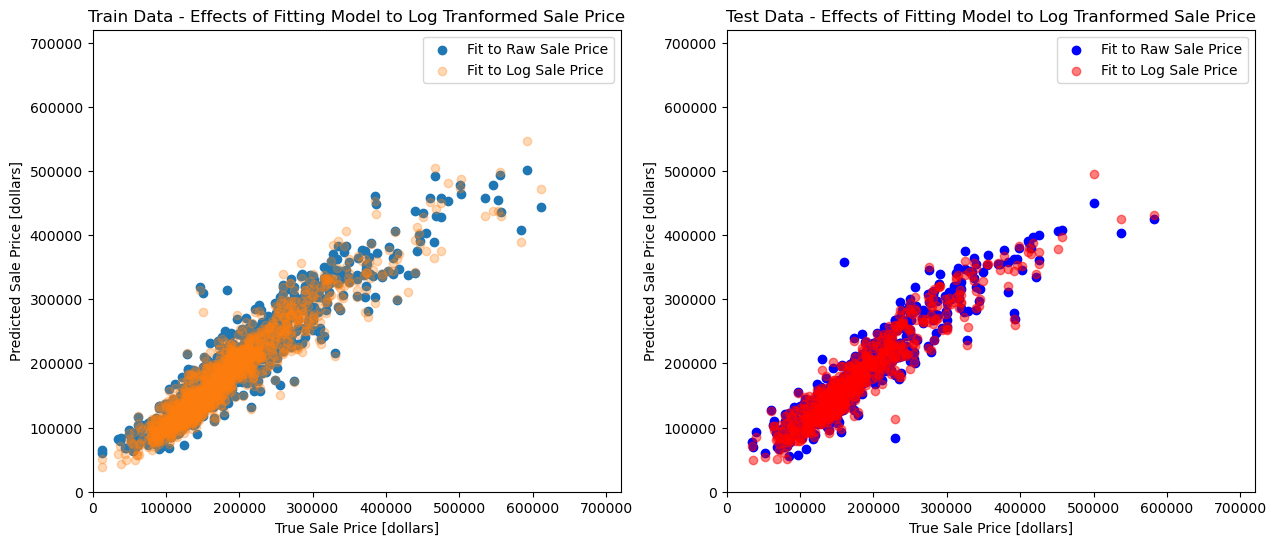

In [86]:
# Plot the predictions versus their true values
# x / y limit source:  https://stackoverflow.com/questions/3777861/how-to-set-the-y-axis-limit

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.scatter(y_train_data_7_poly_nbr, pred_train_data_7_poly_nbr, label = 'Fit to Raw Sale Price')
plt.scatter(y_train_data_7_poly_nbr_log, pred_train_data_7_poly_nbr_log, alpha = 0.3, label = 'Fit to Log Sale Price');
plt.legend()
plt.title('Train Data - Effects of Fitting Model to Log Tranformed Sale Price')
plt.xlabel('True Sale Price [dollars]')
plt.xlim(0, 720000)
plt.ylabel('Predicted Sale Price [dollars]')
plt.ylim(0, 720000)

plt.subplot(1,2,2)
plt.scatter(y_test_data_7_poly_nbr, pred_test_data_7_poly_nbr, label = 'Fit to Raw Sale Price', color = 'blue')
plt.scatter(y_test_data_7_poly_nbr_log, pred_test_data_7_poly_nbr_log, alpha = 0.5, label = 'Fit to Log Sale Price', color = 'red');
plt.legend()
plt.title('Test Data - Effects of Fitting Model to Log Tranformed Sale Price')
plt.xlabel('True Sale Price [dollars]')
plt.xlim(0, 720000)
plt.ylabel('Predicted Sale Price [dollars]')
plt.ylim(0, 720000)
plt.show();


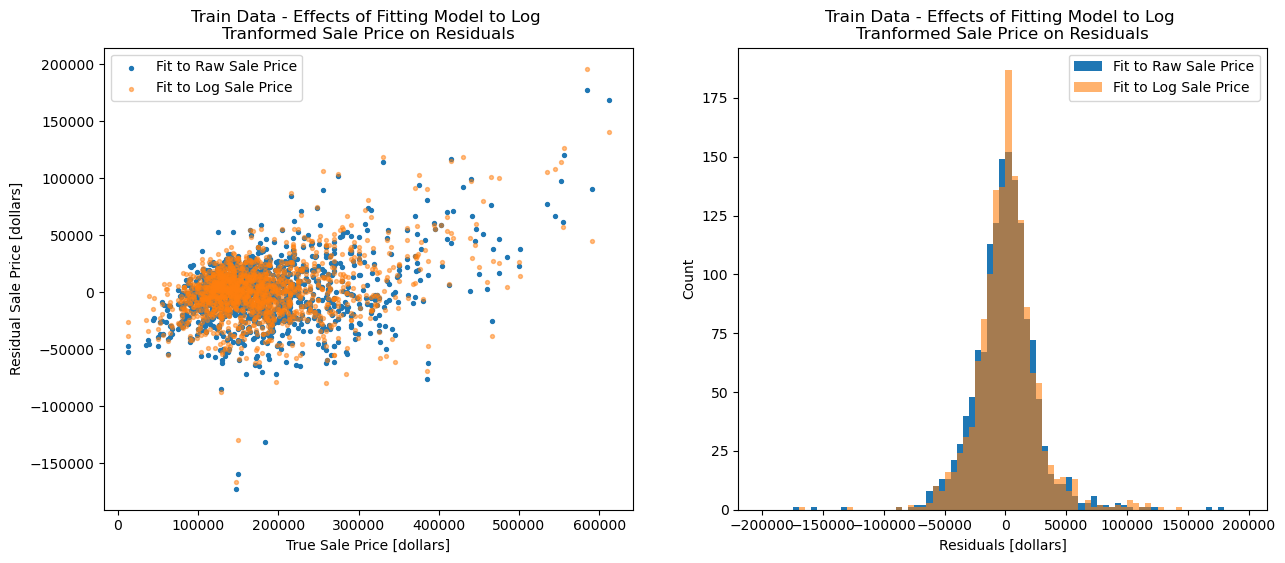

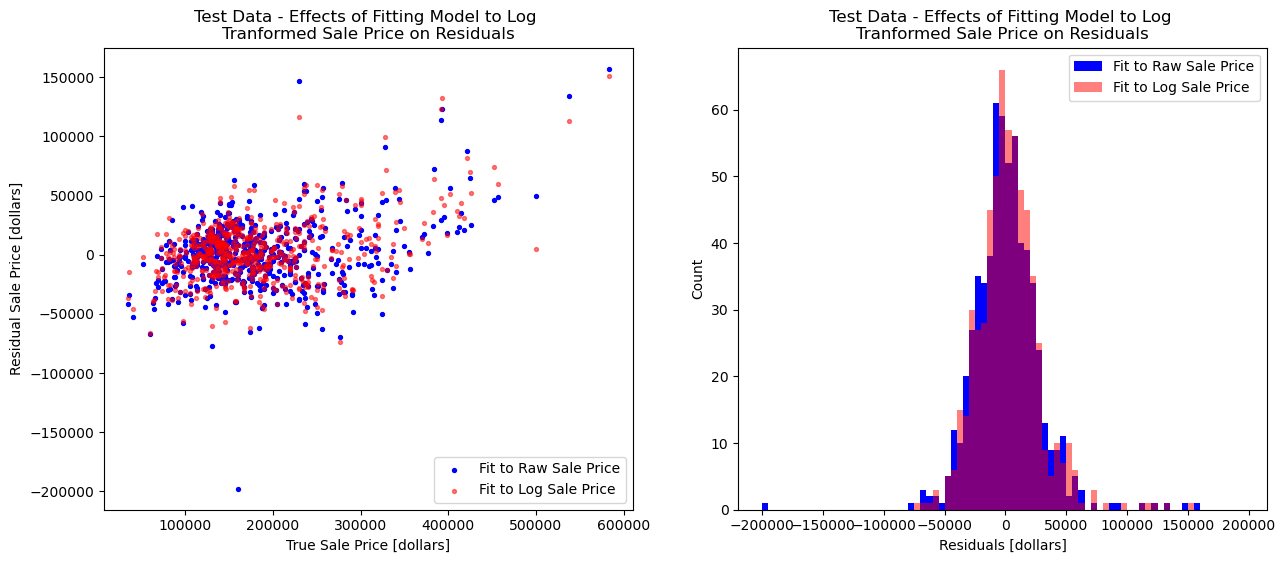

In [87]:
# Residual plots and distributions
# Alternate implementation of subplot, source:  https://www.w3schools.com/python/matplotlib_subplot.asp

# _______________ TRAIN DATA PLOTS _________________________________________

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.scatter(y_train_data_7_poly_nbr, (y_train_data_7_poly_nbr - pred_train_data_7_poly_nbr), label = 'Fit to Raw Sale Price', s=8)
plt.scatter(y_train_data_7_poly_nbr_log, (y_train_data_7_poly_nbr_log - pred_train_data_7_poly_nbr_log), alpha = 0.5, label = 'Fit to Log Sale Price', s=8);
plt.legend()
plt.title('Train Data - Effects of Fitting Model to Log \nTranformed Sale Price on Residuals')
plt.xlabel('True Sale Price [dollars]')
plt.ylabel('Residual Sale Price [dollars]')

# Source on color scale used below to call colors:  https://matplotlib.org/stable/users/prev_whats_new/dflt_style_changes.html
plt.subplot(1,2,2)
plt.hist((y_train_data_7_poly_nbr - pred_train_data_7_poly_nbr), bins = range(-200_000, 200_000, 5_000), alpha = 1, label = 'Fit to Raw Sale Price', color = 'C0')
plt.hist((y_train_data_7_poly_nbr_log - pred_train_data_7_poly_nbr_log), bins = range(-200_000, 200_000, 5_000), alpha = 0.6, label = 'Fit to Log Sale Price', color = 'C1')
plt.legend()
plt.title('Train Data - Effects of Fitting Model to Log \nTranformed Sale Price on Residuals')
plt.xlabel('Residuals [dollars]')
plt.ylabel('Count');

plt.show()

# _______________ TEST DATA PLOTS _________________________________________

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.scatter(y_test_data_7_poly_nbr, (y_test_data_7_poly_nbr - pred_test_data_7_poly_nbr), label = 'Fit to Raw Sale Price', s=8, color = 'blue')
plt.scatter(y_test_data_7_poly_nbr_log, (y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log), alpha = 0.5, label = 'Fit to Log Sale Price', s=8, color = 'red');
plt.legend()
plt.title('Test Data - Effects of Fitting Model to Log \nTranformed Sale Price on Residuals')
plt.xlabel('True Sale Price [dollars]')
plt.ylabel('Residual Sale Price [dollars]')

plt.subplot(1,2,2)
plt.hist((y_test_data_7_poly_nbr - pred_test_data_7_poly_nbr), bins = range(-200_000, 200_000, 5_000), alpha = 1, label = 'Fit to Raw Sale Price', color = 'blue')
plt.hist((y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log), bins = range(-200_000, 200_000, 5_000), alpha = .5, label = 'Fit to Log Sale Price', color = 'red')
plt.legend()
plt.title('Test Data - Effects of Fitting Model to Log \nTranformed Sale Price on Residuals')
plt.xlabel('Residuals [dollars]')
plt.ylabel('Count');

plt.show();

#### Observations:
* Fitting against a log-transformed target variable tends to exacerbate the error for outliers but increase model performance as a whole
* Most residuals are more tightly distributed as a result of the log transformation

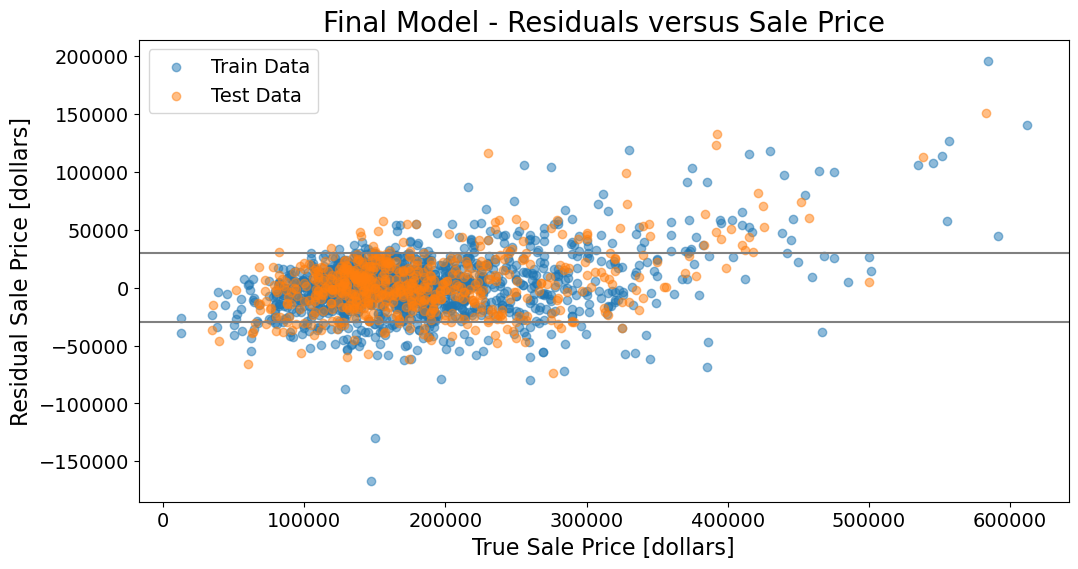

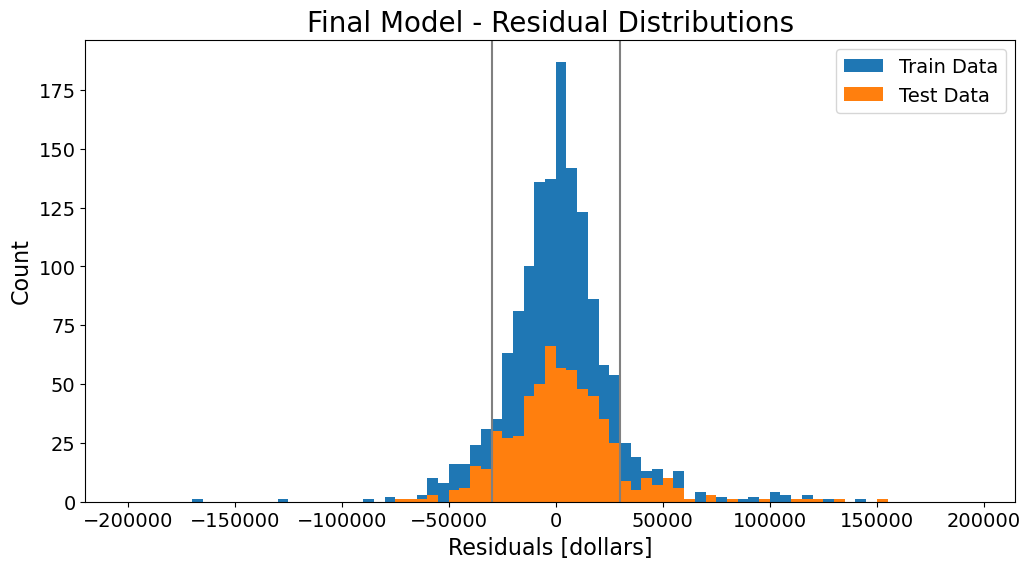

In [88]:
# Make Final Model PLots

# Source for x and y ticks:  https://stackoverflow.com/questions/6390393/make-tick-labels-font-size-smaller
plt.figure(figsize=(12, 6))
plt.scatter(y_train_data_7_poly_nbr_log, (y_train_data_7_poly_nbr_log - pred_train_data_7_poly_nbr_log), alpha = 0.5, label = 'Train Data', color = 'C0');
plt.scatter(y_test_data_7_poly_nbr_log, (y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log), alpha = 0.5, label = 'Test Data', color = 'C1');
plt.legend(fontsize = 14)
plt.title('Final Model - Residuals versus Sale Price', size = 20)
plt.xlabel('True Sale Price [dollars]', size = 16)
plt.ylabel('Residual Sale Price [dollars]', size = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.axhline(y = -30_000, color = 'gray')
plt.axhline(y = 30_000, color = 'gray')
plt.savefig('../images/resid_v_saleprice.png')
plt.show();

# Source on color scale used below to call colors:  https://matplotlib.org/stable/users/prev_whats_new/dflt_style_changes.html
plt.figure(figsize=(12, 6))
plt.hist((y_train_data_7_poly_nbr_log - pred_train_data_7_poly_nbr_log), bins = range(-200_000, 200_000, 5_000), alpha = 1, label = 'Train Data', color = 'C0')
plt.hist((y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log), bins = range(-200_000, 200_000, 5_000), alpha = 1, label = 'Test Data', color = 'C1')
# Code for bin ranges inspired by:  https://www.geeksforgeeks.org/bin-size-in-matplotlib-histogram/  and the doc string
plt.legend(fontsize = 14)
plt.title('Final Model - Residual Distributions', size = 20)
plt.xlabel('Residuals [dollars]', size = 16)
plt.ylabel('Count', size = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.axvline(x = -30_000, color = 'gray')
plt.axvline(x = 30_000, color = 'gray')
plt.savefig('../images/resid_distr.png')
plt.show();

#### Observations:
* A clear upward trend in the residuals can be observed indicating the the model struggles with higher value homes
* The boundaries shown represent the +/-$30k requirement which is met on average and by 83.8% of training data

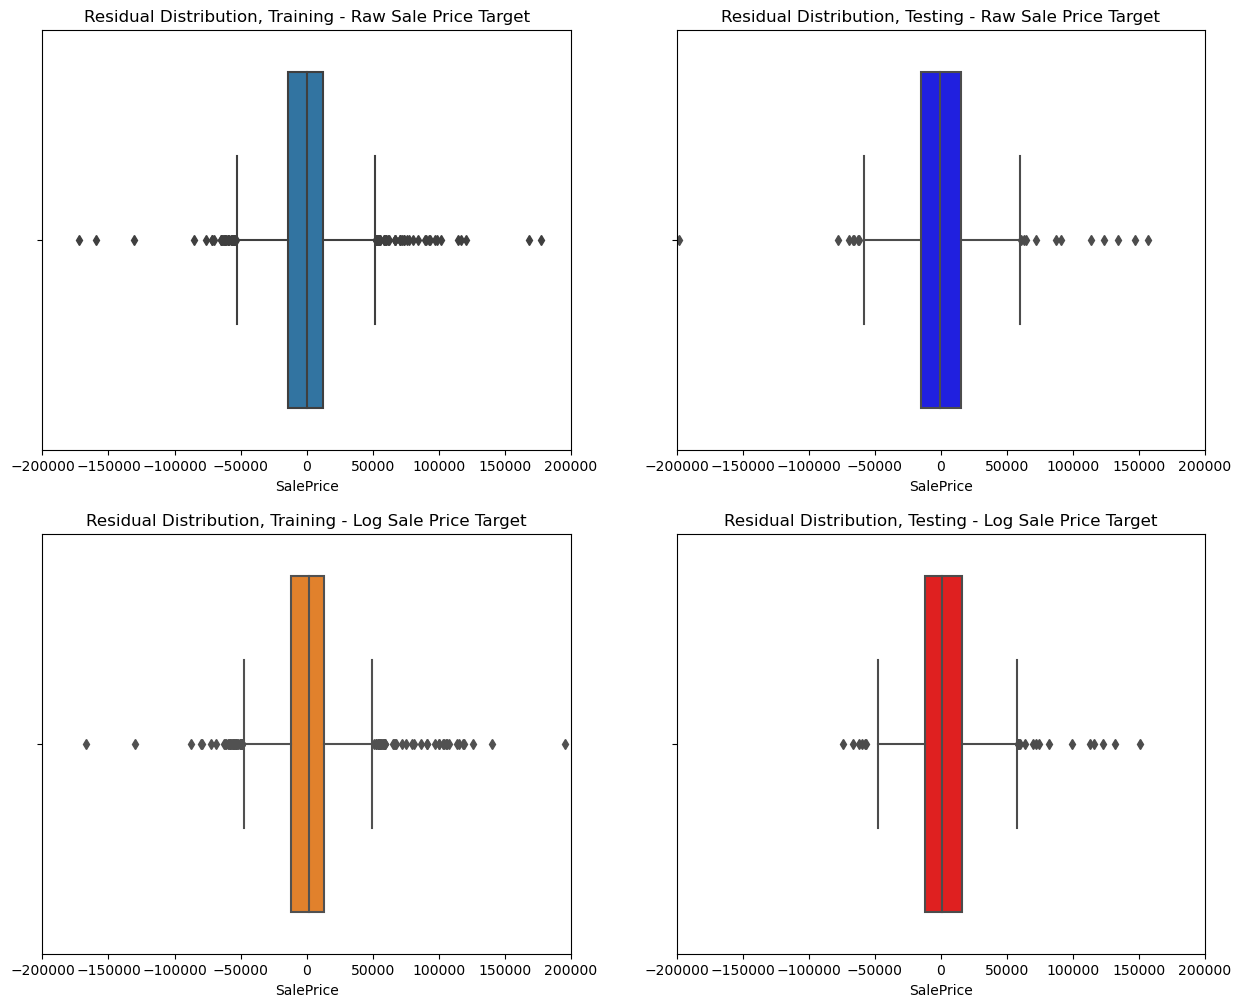

In [118]:
plt.figure(figsize=(15, 12))

plt.subplot(2,2,1)
sns.boxplot(x = (y_train_data_7_poly_nbr - pred_train_data_7_poly_nbr), data = (y_train_data_7_poly_nbr - pred_train_data_7_poly_nbr), color = 'C0')
plt.title('Residual Distribution, Training - Raw Sale Price Target')
plt.xlim(-200000, 200000)
plt.subplot(2,2,3)
sns.boxplot(x = (y_train_data_7_poly_nbr_log - pred_train_data_7_poly_nbr_log), data = (y_train_data_7_poly_nbr_log - pred_train_data_7_poly_nbr_log), color = 'C1')
plt.title('Residual Distribution, Training - Log Sale Price Target')
plt.xlim(-200000, 200000)

plt.subplot(2,2,2)
sns.boxplot(x = (y_test_data_7_poly_nbr - pred_test_data_7_poly_nbr), data = (y_test_data_7_poly_nbr - pred_test_data_7_poly_nbr), color = 'blue')
plt.title('Residual Distribution, Testing - Raw Sale Price Target')
plt.xlim(-200000, 200000)
plt.subplot(2,2,4)
sns.boxplot(x = (y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log), data = (y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log), color = 'red')
plt.title('Residual Distribution, Testing - Log Sale Price Target')
plt.xlim(-200000, 200000)
plt.show();

#### Observations:
* The box plots above show how the log transformation brings in some outliers and makes others far more extreme

# 5 - Incorporate Regularization Methods on NLR2 Modification 1 Log Transformed Target

Regularization methods can be used to prevent the model from over fitting.  The effects of adding ridge and lasso regularization methods to these models will be observed.

In [90]:
# Create a funciton to make train test splits, fit the model, and all that stuff, but with the log target ... 
#  ... AND it maust also implement Ridge Regularization

def split_fit_metric_frame_log_ridge_cv(X, y, mod_name, a_min, a_max, spread):
    # Create a train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # ________________________________________________________
    # Scale the features with StandardScaler:    
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train) # Fit and transform the training data
    X_test_sc = sc.transform(X_test) # ONLY transform the test data
    
    # ________________________________________________________
    # Take the log of the target variable(s):
    y_train_log, y_test_log = np.log(y_train), np.log(y_test)
    # ________________________________________________________
    
    # Create local Ridge instance and alphas:
    alphas = np.logspace(a_min, a_max, spread)
    
    ridge_cv = RidgeCV(alphas = alphas, cv = 5)
    
    # Fit the function:
    ridge_cv.fit(X_train_sc, y_train_log) # fit against the log with the Z-scaled data
    
    # Create predictions:
    pred_train_log = ridge_cv.predict(X_train_sc) # the model was trained aginst a log target, and thus the predictions are log
    pred_test_log = ridge_cv.predict(X_test_sc)

    #_________________________________________________________
    # Get R2 train & test scores:
    r2_train_log = ridge_cv.score(X_train_sc, y_train_log) # gotta compare against the log values
    r2_test_log = ridge_cv.score(X_test_sc, y_test_log)
    
    # Print the alpha and best score:
    print(f'best alpha:  {ridge_cv.alpha_}')
    print(f'best R2 score:  {ridge_cv.best_score_}')
    
    # Transform prior log values:
    pred_train = np.exp(pred_train_log)
    pred_test = np.exp(pred_test_log)
    
    # Manually calcualte R2 for non-log values:
    r2_train = 1 - (sum((y_train - pred_train)**2) / sum((y_train - y_train.mean())**2))
    r2_test = 1 - (sum((y_test - pred_test)**2) / sum((y_test - y_test.mean())**2)) 
    #_________________________________________________________
    
    # Get train & test RMSE:
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    
    # Get mean absolute error:
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    # Get cross validation scores and their mean
    # cv_train = cross_val_score(ridge_cv, X_train, y_train, )
    # cv_train_mean = cross_val_score(ridge_cv, X_train, y_train).mean()
    
    # Percentage within $30k
    within_30k = (abs(y_train - pred_train) < 30_000).mean() * 100
       
    # Sounce for numpy.around():  https://numpy.org/doc/stable/reference/generated/numpy.around.html
    items = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'mae_train', 'mae_test', 'Within $30k (%)',
             'cv_train_mean', 'cv_train_1', 'cv_train_2', 'cv_train_3', 'cv_train_4', 'cv_train_5',
             'R2_train_log', 'R2_test_log',]
    variables = [round(r2_train, 4), 
                 round(r2_test, 4), 
                 round(rmse_train), 
                 round(rmse_test), 
                 round(mae_train), 
                 round(mae_test),
                 round(within_30k, 4),
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 round(r2_train_log, 4), 
                 round(r2_test_log, 4),
                ]

                 # np.around(cv_train_mean, 4),
                 # np.around(cv_train[0], 4),
                 # np.around(cv_train[1], 4),
                 # np.around(cv_train[2], 4),
                 # np.around(cv_train[3], 4),
                 # np.around(cv_train[4], 4),    
    
    
    # Create global variables in the background so they can be called later:
    #  Source:  Special thanks to Alanna Besaw for help finding the globals() function!
    #  Source2:  https://www.geeksforgeeks.org/python-globals-function/
    globals()[f'X_train_{mod_name}'] = X_train
    globals()[f'X_test_{mod_name}'] = X_test
    globals()[f'y_train_{mod_name}'] = y_train
    globals()[f'y_test_{mod_name}'] = y_test    
    globals()[f'pred_train_{mod_name}'] = pred_train    
    globals()[f'pred_test_{mod_name}'] = pred_test    
    globals()[f'pred_train_log_{mod_name}'] = pred_train_log    
    globals()[f'pred_test_log_{mod_name}'] = pred_test_log     
    
    # Return a dataframe with all the metrics above!
    return pd.DataFrame(variables, index = items, columns = [f'{mod_name}'])

    

In [91]:
# Test the ridge function to determine the value of alpha before merging the model metrics dataframe
#  Then, refine the alpha parameter ranges, and merge the dataframe with model metrics
split_fit_metric_frame_log_ridge_cv(X7_poly_nbr, y6_poly, 'data_7_poly_nbr_log_ridge', -1, 4, 100)

best alpha:  3.2745491628777286
best R2 score:  0.8490862535538749


data_7_poly_nbr_log_ridge
R2_train                            0.8935
R2_test                             0.8888
RMSE_train                      25918.0000
RMSE_test                       26277.0000
mae_train                       17744.0000
mae_test                        18670.0000
Within $30k (%)                    83.5540
cv_train_mean                          NaN
cv_train_1                             NaN
cv_train_2                             NaN
cv_train_3                             NaN
cv_train_4                             NaN
cv_train_5                             NaN
R2_train_log                        0.8728
R2_test_log                         0.8676

In [92]:
# Run again but with alpha limits better suited to the best alpha (whcih is currently between 10^0 and 10^1):
model_metrics = model_metrics.merge(split_fit_metric_frame_log_ridge_cv(X7_poly_nbr, y6_poly, 'data_7_poly_nbr_log_ridge', 0, 1, 100), left_index=True, right_index=True, how = 'right')
model_metrics

best alpha:  3.1257158496882362
best R2 score:  0.8490867522771529


ILR      data_1      data_2      data_3      data_4  \
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262   
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521   
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000   
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000   
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000   
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000   
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547   
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188   
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590   
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415   
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369   
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626   
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939   
R2_train_log            NaN         NaN         NaN         NaN         NaN   
R2_test_log             NaN         NaN         NaN         NaN         NaN   

                 data_5_poly  data_6_poly  data_7_poly_nbr  \
R2_train              0.8735       0.8817           0.8902   
R2_test               0.8697       0.8715           0.8760   
RMSE_train        28250.0000   27314.0000       26319.0000   
RMSE_test         28437.0000   28241.0000       27749.0000   
mae_train         19571.0000   19080.0000       18437.0000   
mae_test          20062.0000   19799.0000       19569.0000   
Within $30k (%)      81.3240      81.5331          82.2997   
cv_train_mean         0.8135       0.7955           0.8067   
cv_train_1            0.8575       0.8737           0.8732   
cv_train_2            0.8554       0.8605           0.8740   
cv_train_3            0.8646       0.8517           0.8614   
cv_train_4            0.8638       0.8691           0.8772   
cv_train_5            0.6263       0.5223           0.5479   
R2_train_log             NaN          NaN              NaN   
R2_test_log              NaN          NaN              NaN   

                 data_7_poly_nbr_log  data_7_poly_nbr_log_ridge  
R2_train                      0.8946                     0.8935  
R2_test                       0.8921                     0.8888  
RMSE_train                25789.0000                 25921.0000  
RMSE_test                 25887.0000                 26279.0000  
mae_train                 17692.0000                 17745.0000  
mae_test                  18643.0000                 18671.0000  
Within $30k (%)              83.7631                    83.5540  
cv_train_mean                 0.8067                        NaN  
cv_train_1                    0.8732                        NaN  
cv_train_2                    0.8740                        NaN  
cv_train_3                    0.8614                        NaN  
cv_train_4                    0.8772                        NaN  
cv_train_5                    0.5479                        NaN  
R2_train_log                  0.8768                     0.8729  
R2_test_log                   0.8662                     0.8676

In [93]:
# Create a funciton to make train test splits, fit the model, and all that stuff, but with the log target ... 
#  ... AND it maust also implement LASSO Regularization

def split_fit_metric_frame_log_lasso_cv(X, y, mod_name, a_min, a_max, spread):
    # Create a train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # ________________________________________________________
    # Scale the features with StandardScaler:    
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train) # Fit and transform the training data
    X_test_sc = sc.transform(X_test) # ONLY transform the test data
    
    # ________________________________________________________
    # Take the log of the target variable(s):
    y_train_log, y_test_log = np.log(y_train), np.log(y_test)
    # ________________________________________________________
    
    # Create local Ridge instance and alphas:
    alphas = np.logspace(a_min, a_max, spread)
    
    lasso_cv = LassoCV(alphas = alphas, cv = 5)
    
    # Fit the function:
    lasso_cv.fit(X_train_sc, y_train_log) # fit against the log with the Z-scaled data
    
    # Create predictions:
    pred_train_log = lasso_cv.predict(X_train_sc) # the model was trained aginst a log target, and thus the predictions are log
    pred_test_log = lasso_cv.predict(X_test_sc)

    #_________________________________________________________
    # Get R2 train & test scores:
    r2_train_log = lasso_cv.score(X_train_sc, y_train_log) # gotta compare against the log values
    r2_test_log = lasso_cv.score(X_test_sc, y_test_log)
    
    # Print the alpha and best score:
    print(f'Best alpha:  {lasso_cv.alpha_}')
    
    # Transform prior log values:
    pred_train = np.exp(pred_train_log)
    pred_test = np.exp(pred_test_log)
    
    # Manually calcualte R2 for non-log values:
    r2_train = 1 - (sum((y_train - pred_train)**2) / sum((y_train - y_train.mean())**2))
    r2_test = 1 - (sum((y_test - pred_test)**2) / sum((y_test - y_test.mean())**2)) 
    #_________________________________________________________
    
    # Get train & test RMSE:
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    
    # Get mean absolute error:
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    # Get cross validation scores and their mean
    # cv_train = cross_val_score(ridge_cv, X_train, y_train, )
    # cv_train_mean = cross_val_score(ridge_cv, X_train, y_train).mean()
    
    # Percentage within $30k
    within_30k = (abs(y_train - pred_train) < 30_000).mean() * 100
       
    # Sounce for numpy.around():  https://numpy.org/doc/stable/reference/generated/numpy.around.html
    items = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'mae_train', 'mae_test', 'Within $30k (%)',
             'cv_train_mean', 'cv_train_1', 'cv_train_2', 'cv_train_3', 'cv_train_4', 'cv_train_5',
             'R2_train_log', 'R2_test_log',]
    variables = [round(r2_train, 4), 
                 round(r2_test, 4), 
                 round(rmse_train), 
                 round(rmse_test), 
                 round(mae_train), 
                 round(mae_test),
                 round(within_30k, 4),
                 None,
                 None,
                 None,
                 None,
                 None,
                 None,
                 round(r2_train_log, 4), 
                 round(r2_test_log, 4),
                ]

                 # np.around(cv_train_mean, 4),
                 # np.around(cv_train[0], 4),
                 # np.around(cv_train[1], 4),
                 # np.around(cv_train[2], 4),
                 # np.around(cv_train[3], 4),
                 # np.around(cv_train[4], 4),    
    
    
    # Create global variables in the background so they can be called later:
    #  Source:  Special thanks to Alanna Besaw for help finding the globals() function!
    #  Source2:  https://www.geeksforgeeks.org/python-globals-function/
    globals()[f'X_train_{mod_name}'] = X_train
    globals()[f'X_test_{mod_name}'] = X_test
    globals()[f'y_train_{mod_name}'] = y_train
    globals()[f'y_test_{mod_name}'] = y_test    
    globals()[f'pred_train_{mod_name}'] = pred_train    
    globals()[f'pred_test_{mod_name}'] = pred_test    
    globals()[f'pred_train_log_{mod_name}'] = pred_train_log    
    globals()[f'pred_test_log_{mod_name}'] = pred_test_log     
    
    # Return a dataframe with all the metrics above!
    return pd.DataFrame(variables, index = items, columns = [f'{mod_name}'])

In [94]:
# Run the function with lasso regularization without merging into the model metrics dataframe
#   Then, refine alpha parameter limits and merge with e model metrics dataframe
split_fit_metric_frame_log_lasso_cv(X7_poly_nbr, y6_poly, 'data_7_poly_nbr_log_lasso', -3, 2, 100)

# Note, this block produces a convergence warning that is supressed

Best alpha:  0.001


C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02052660158767594, tolerance: 0.018950607032047904
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02460213943642131, tolerance: 0.018950607032047904
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024247505515958778, tolerance: 0.020491902106193147
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

data_7_poly_nbr_log_lasso
R2_train                            0.8913
R2_test                             0.8880
RMSE_train                      26185.0000
RMSE_test                       26370.0000
mae_train                       17900.0000
mae_test                        18728.0000
Within $30k (%)                    82.9268
cv_train_mean                          NaN
cv_train_1                             NaN
cv_train_2                             NaN
cv_train_3                             NaN
cv_train_4                             NaN
cv_train_5                             NaN
R2_train_log                        0.8683
R2_test_log                         0.8679

In [95]:
model_metrics = model_metrics.merge(split_fit_metric_frame_log_lasso_cv(X7_poly_nbr, y6_poly, 'data_7_poly_nbr_log_lasso', -7, -3, 100), left_index=True, right_index=True, how = 'right')
model_metrics

# Note, this block produces a convergence warning that is supressed

C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23429048335977498, tolerance: 0.018950607032047904
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23319033990122762, tolerance: 0.018950607032047904
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021137812641306652, tolerance: 0.018950607032047904
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

Best alpha:  1e-07


C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.575379877427661, tolerance: 0.01997561601108815
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.64294433775855, tolerance: 0.01997561601108815
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.704666813957033, tolerance: 0.01997561601108815
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Dan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Co

ILR      data_1      data_2      data_3      data_4  \
R2_train             0.8621      0.8269      0.8556      0.8743      0.8262   
R2_test              0.7976      0.7389      0.7856      0.7769      0.7521   
RMSE_train       29492.0000  33043.0000  30177.0000  28155.0000  33114.0000   
RMSE_test        35452.0000  40265.0000  36486.0000  37221.0000  39233.0000   
mae_train        19786.0000  22611.0000  20319.0000  18457.0000  21256.0000   
mae_test         20797.0000  23716.0000  21498.0000  20792.0000  22618.0000   
Within $30k (%)     80.8362     75.4007     79.6516     82.7178     78.9547   
cv_train_mean        0.8232      0.7921      0.8214      0.8358      0.8188   
cv_train_1           0.8366      0.8321      0.8385      0.8737      0.8590   
cv_train_2           0.8572      0.8141      0.8529      0.8802      0.8415   
cv_train_3           0.7984      0.7651      0.8056      0.8111      0.8369   
cv_train_4           0.8540      0.8431      0.8490      0.8609      0.8626   
cv_train_5           0.7699      0.7060      0.7608      0.7532      0.6939   
R2_train_log            NaN         NaN         NaN         NaN         NaN   
R2_test_log             NaN         NaN         NaN         NaN         NaN   

                 data_5_poly  data_6_poly  data_7_poly_nbr  \
R2_train              0.8735       0.8817           0.8902   
R2_test               0.8697       0.8715           0.8760   
RMSE_train        28250.0000   27314.0000       26319.0000   
RMSE_test         28437.0000   28241.0000       27749.0000   
mae_train         19571.0000   19080.0000       18437.0000   
mae_test          20062.0000   19799.0000       19569.0000   
Within $30k (%)      81.3240      81.5331          82.2997   
cv_train_mean         0.8135       0.7955           0.8067   
cv_train_1            0.8575       0.8737           0.8732   
cv_train_2            0.8554       0.8605           0.8740   
cv_train_3            0.8646       0.8517           0.8614   
cv_train_4            0.8638       0.8691           0.8772   
cv_train_5            0.6263       0.5223           0.5479   
R2_train_log             NaN          NaN              NaN   
R2_test_log              NaN          NaN              NaN   

                 data_7_poly_nbr_log  data_7_poly_nbr_log_ridge  \
R2_train                      0.8946                     0.8935   
R2_test                       0.8921                     0.8888   
RMSE_train                25789.0000                 25921.0000   
RMSE_test                 25887.0000                 26279.0000   
mae_train                 17692.0000                 17745.0000   
mae_test                  18643.0000                 18671.0000   
Within $30k (%)              83.7631                    83.5540   
cv_train_mean                 0.8067                        NaN   
cv_train_1                    0.8732                        NaN   
cv_train_2                    0.8740                        NaN   
cv_train_3                    0.8614                        NaN   
cv_train_4                    0.8772                        NaN   
cv_train_5                    0.5479                        NaN   
R2_train_log                  0.8768                     0.8729   
R2_test_log                   0.8662                     0.8676   

                 data_7_poly_nbr_log_lasso  
R2_train                            0.8919  
R2_test                             0.8876  
RMSE_train                      26111.0000  
RMSE_test                       26417.0000  
mae_train                       17879.0000  
mae_test                        18779.0000  
Within $30k (%)                    83.2753  
cv_train_mean                          NaN  
cv_train_1                             NaN  
cv_train_2                             NaN  
cv_train_3                             NaN  
cv_train_4                             NaN  
cv_train_5                             NaN  
R2_train_log                        0.8735  
R2_test_log       

#### Observations:
* Above, both ridge and lasso regularization methods have degraded the final model performance

# 6 - Final Model Selection, Data Dictionary, and LINEM Assumptions

## 6.1 - Final Model Selection
The model labeled 'data_7_poly_nbr_log' is the best model to use across all three performance metrics of r-squared value, root mean sqaured error, and the mean absolute error.  This model includes a variety of numerical and categorical features including first and second order interaction terms.  With these interaction terms, the model exhibits multicolinearity, though this is acceptable for a prediction model where inference is of lesser importance.

This model was also selected to incorporate both ridge and lasso regularization techniques.  These methods tended to degrade the performance of the model as the r-sqaured values for both the training and test data were nearly identical in the model without regularization.

### 6.1.1 - How this Model Works
This model takes in numerical features selected for their correlation to sale price or impact on model perofrmance.  They include the total basement sqaure footage, garage square footage, overall home quality, year the home was remodeled or added to, the total square feet, the square footage of masonry, and the number of fireplaces.  These numerical features are then used to create interaction terms which are products of each of these features and themselves creating first and second order polynomial terms.  Including these polynomial features was founfd to greatly enhance the model performance.  Categorical columns which were one hot encoded are included for eight of the 28 total neighborhoods in Ames, Iowa which - when included in the model - enhanced its performance.

The model itself is a simple linear regression model performing ordinary least squares regression.  It creates a multi-dimensional 'line of best fit' with slope and intercept terms for each feature.  As this model is geared towards prediction, these terms are of lesser importance, especially considering that this model contains multicolinearity.  The model is fitted against log-transformed sale price data as this was seen to improve performance.  The prediction made by this model themselves are log data which are then exponentiated to return outputs in the original sal price units of dollars.

### 6.1.2 - Final Model Performance Characteristics
* The Mean Absolute Errors (MAEs) of the model on the trainging and test datasets respectively are \\$17,692 and \\$18,643, both well within the \\$30,000 target
* The Root Mean Sqaured Errors (RMSEs) of the model on the training and test datasets respctively are \\$25789 and \\$25887.  The closeness of these numebrs suggest that model is strking a good balance between bias and variance
* The R-Sqaured values of the model on the raining and test datasets respctively are 0.8946 and 0.8921.  This means that approximately 89% of the variability in the target variable can be explained by this model with the selected features.  The closeness of these numebrs suggest that model is strking a good balance between bias and variance

### 6.1.3 - Note on Model Coefficients for Model Fit to Log-transformed Data
As the purpose of this model is to make predictions, interpreting the coefficients is of lesser importance.  However, it should be noted that this inference would become a bit more abstract with the final model given that the model was fit against the log transformed sale price data.  Thus, if they were to be interpreted, the number would indicate a multiplicative increase in the sale price (equal to e raised to the power of that coefficient) for every unit increase in a numerical feature or with the activation of a categorical feature relative to a baseline (assumes all else is held constant).

## 6.2 Final Model Data Dictionary
The data dictionary for the final model is provided below:


| Feature                      | Data Type | Dataset                     | Description                                                                            |
|------------------------------|-----------|-----------------------------|----------------------------------------------------------------------------------------|
| Total Bsmt SF                | Float64   | Kaggle, Ames, Iowa          | TotalBsmtSF: Total square feet of basement area                                        |
| Garage Area                  | Float64   | Kaggle, Ames, Iowa          | GarageArea: Size of garage in square feet                                              |
| Overall Qual                 | Float64   | Kaggle, Ames, Iowa          | OverallQual: Overall material and finish quality                                       |
| Year Remod/Add               | Float64   | Kaggle, Ames, Iowa          | YearRemodAdd: Remodel date (same as construction date if no remodeling or   additions) |
| Gr Liv Area                  | Float64   | Kaggle, Ames, Iowa          | GrLivArea: Above grade (ground) living area square feet                                |
| Mas Vnr Area                 | Float64   | Kaggle, Ames, Iowa          | MasVnrArea: Masonry veneer area in square feet                                         |
| Fireplaces                   | Float64   | Kaggle, Ames, Iowa          | Fireplaces: Number of fireplaces                                                       |
| Total Bsmt SF^2              | Float64   | Derived                     | Second order interaction term                                                          |
| Total Bsmt SF Garage Area    | Float64   | Derived                     | First order interaction term                                                           |
| Total Bsmt SF Overall Qual   | Float64   | Derived                     | First order interaction term                                                           |
| Total Bsmt SF Year Remod/Add | Float64   | Derived                     | First order interaction term                                                           |
| Total Bsmt SF Gr Liv Area    | Float64   | Derived                     | First order interaction term                                                           |
| Total Bsmt SF Mas Vnr Area   | Float64   | Derived                     | First order interaction term                                                           |
| Total Bsmt SF Fireplaces     | Float64   | Derived                     | First order interaction term                                                           |
| Garage Area^2                | Float64   | Derived                     | Second order interaction term                                                          |
| Garage Area Overall Qual     | Float64   | Derived                     | First order interaction term                                                           |
| Garage Area Year Remod/Add   | Float64   | Derived                     | First order interaction term                                                           |
| Garage Area Gr Liv Area      | Float64   | Derived                     | First order interaction term                                                           |
| Garage Area Mas Vnr Area     | Float64   | Derived                     | First order interaction term                                                           |
| Garage Area Fireplaces       | Float64   | Derived                     | First order interaction term                                                           |
| Overall Qual^2               | Float64   | Derived                     | Second order interaction term                                                          |
| Overall Qual Year Remod/Add  | Float64   | Derived                     | First order interaction term                                                           |
| Overall Qual Gr Liv Area     | Float64   | Derived                     | First order interaction term                                                           |
| Overall Qual Mas Vnr Area    | Float64   | Derived                     | First order interaction term                                                           |
| Overall Qual Fireplaces      | Float64   | Derived                     | First order interaction term                                                           |
| Year Remod/Add^2             | Float64   | Derived                     | Second order interaction term                                                          |
| Year Remod/Add Gr Liv Area   | Float64   | Derived                     | First order interaction term                                                           |
| Year Remod/Add Mas Vnr Area  | Float64   | Derived                     | First order interaction term                                                           |
| Year Remod/Add Fireplaces    | Float64   | Derived                     | First order interaction term                                                           |
| Gr Liv Area^2                | Float64   | Derived                     | Second order interaction term                                                          |
| Gr Liv Area Mas Vnr Area     | Float64   | Derived                     | First order interaction term                                                           |
| Gr Liv Area Fireplaces       | Float64   | Derived                     | First order interaction term                                                           |
| Mas Vnr Area^2               | Float64   | Derived                     | Second order interaction term                                                          |
| Mas Vnr Area Fireplaces      | Float64   | Derived                     | First order interaction term                                                           |
| Fireplaces^2                 | Float64   | Derived                     | Second order interaction term                                                          |
| Neighborhood_Edwards         | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_IDOTRR          | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_NAmes           | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_NoRidge         | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_NridgHt         | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_OldTown         | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_Somerst         | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
| Neighborhood_StoneBr         | uint8     | Kaggle, Ames, Iowa, Encoded | Neighborhood: Physical locations within Ames city limits                               |
    
Codebook / Data Dictionary Entries for Original Features (not interaction terms) Taken Directly from the Kaggle Competition Site: [link](https://www.kaggle.com/competitions/dsir-320-project-2-regression-challenge/data)


## 6.3 - LINEM Assumptions
It was stated previously that the prupose of this model is to predict the sale price of a home given a set of parameters about the home and its location.  This model is not concerned with accurately inferring the numerical relationship between variables.  This means that some of the line assumptions below can be violated.

### L - Linearity:  
Generally upheld - A pairplot of the 'preliminary features' in Section 2 shows many approximately linear relationships between different varialbes and the sale price.  While they are not perfectly linear, it can be seen that the datapoints are organized in a fashion that would visually establish a linear direction.  Relationships of this nature are sufficient for this model.  That being said, some features are included with lower correlations to the saleprice and the model performance metrics are left to be the final determination of whether or not a feature is useful in this model for the sake of predicting the sale price.

### I - Independence:
Generally assumed to be upheld - Practically speaking, independence between variables must be assumed.  In reality, it is nearly impossible guarantee that these variables do not influence eachother in some way, especially where human judgement is involved in rating the metrics collected and set/accepting the sale price (among other things).

### N - Normality of Errors:
Questionably upheld - As the target variable, sale price, showed a right skew to the data, a log transformation was able to make this variable more normal, but not perfectly normal.  The distrubtions of the residuals showed a similar skew, though were relatively nromal. 

### E - Equal Variance:
Violated - When viewing a plot of the residuals versus the sale price, it can be seen that heteroscedasticity is present where higher valued homes tend to show and upward trend in error.  This indicates that there are some effects in the residuals that are not adequately captured in the model.

### M - Multicolinearity:
Violated - As this model contains interaction termns which are products of each other, multicolinearity is present.  Some base features are also selected which show some correlation with one another.  As this model is optimized for prediction and not inference, this violation is acceptable.

# 7 - Process Test Data and Create Submission Dataset

In [96]:
actual_test = pd.read_csv('../datasets/test.csv')

In [97]:
data_test = actual_test[['Total Bsmt SF', 'Garage Area', 'Overall Qual', 'Year Remod/Add', 'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces']].copy()

In [98]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Total Bsmt SF   878 non-null    int64  
 1   Garage Area     878 non-null    int64  
 2   Overall Qual    878 non-null    int64  
 3   Year Remod/Add  878 non-null    int64  
 4   Gr Liv Area     878 non-null    int64  
 5   Mas Vnr Area    877 non-null    float64
 6   Fireplaces      878 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 48.1 KB


In [99]:
data_test.fillna(0, inplace=True)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Total Bsmt SF   878 non-null    int64  
 1   Garage Area     878 non-null    int64  
 2   Overall Qual    878 non-null    int64  
 3   Year Remod/Add  878 non-null    int64  
 4   Gr Liv Area     878 non-null    int64  
 5   Mas Vnr Area    878 non-null    float64
 6   Fireplaces      878 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 48.1 KB


In [100]:
data_test_poly = poly.fit_transform(data_test)

In [101]:
data_test_poly = pd.DataFrame(data_test_poly, columns=poly.get_feature_names_out(data_test.columns))

In [102]:
data_test_poly['Neighborhood'] = actual_test['Neighborhood']

In [103]:
data_test_poly = pd.get_dummies(columns=['Neighborhood'], data = data_test_poly, drop_first= True)

In [104]:
data_test_poly = data_test_poly[['Total Bsmt SF', 'Garage Area', 'Overall Qual', 'Year Remod/Add',
       'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces', 'Total Bsmt SF^2',
       'Total Bsmt SF Garage Area', 'Total Bsmt SF Overall Qual',
       'Total Bsmt SF Year Remod/Add', 'Total Bsmt SF Gr Liv Area',
       'Total Bsmt SF Mas Vnr Area', 'Total Bsmt SF Fireplaces',
       'Garage Area^2', 'Garage Area Overall Qual',
       'Garage Area Year Remod/Add', 'Garage Area Gr Liv Area',
       'Garage Area Mas Vnr Area', 'Garage Area Fireplaces', 'Overall Qual^2',
       'Overall Qual Year Remod/Add', 'Overall Qual Gr Liv Area',
       'Overall Qual Mas Vnr Area', 'Overall Qual Fireplaces',
       'Year Remod/Add^2', 'Year Remod/Add Gr Liv Area',
       'Year Remod/Add Mas Vnr Area', 'Year Remod/Add Fireplaces',
       'Gr Liv Area^2', 'Gr Liv Area Mas Vnr Area', 'Gr Liv Area Fireplaces',
       'Mas Vnr Area^2', 'Mas Vnr Area Fireplaces', 'Fireplaces^2',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr']]

In [105]:
# Re-train the best model from before with the input datasets

lr_final = LinearRegression()

X_train_final = X_train_data_7_poly_nbr_log
y_train_final_log = np.log(y_train_data_7_poly_nbr_log)

lr_final.fit(X_train_final, y_train_final_log)

pred_train_final_log = lr_final.predict(X_train_final)
pred_test_final_log = lr_final.predict(data_test_poly) # Use the new data data!

pred_train_final = np.exp(pred_train_final_log)
pred_test_final = np.exp(pred_test_final_log)

In [106]:
# Test to make sure that the model trained exactly as before:
set(pred_train_data_7_poly_nbr_log == pred_train_final)

{True}

In [107]:
# Create the submission dataframe, and export to csv:
submit = actual_test
submit['saleprice'] = pd.Series(pred_test_final)
submit[['Id', 'saleprice']].to_csv('rossetti_final_model.csv', index = False)

# 8 - Model Limitations and Additional Refinements
* Stated previously, these models are not geared towards inference and shound not be used to establish confident relationships between the selected features and the target variable
* With more time, more attention could be given to categorical variables which may help to better characterize the sale prices of higher value homes than the current model
* The model could stand to be de-featured to make room for other higher-correlation features.  While it has been stated that multicolinearity exists but is acceptable, some terms may be found to be redundant with more time

# 9 - Conclusions:
* A model can be created which will predict home prices in Ames Iowa within a Mean Absolute Error (MAE) \\$30,000
    * With the final model 83.8% of sale prices were prediced to within $30,000
* The model exibits a good balance of bias and variance as the R-sqaured terms of this model on both the training and test data are nearly identical
* The model can be further refined to incorporate more features, but as it stands, must collect the following information from users when estimating a home sale price:
    * Total basement square footage
    * Garage square footage
    * Overall quality of the home on a 1 - 10 scale with 1 being poor and 10 being excellent
    * Year the home was remodeled or added to, defaulting to the year it was built if not remodeled or added to
    * Total Square footage (not including the basement and garage) also known as the 'graded living area'
    * Square footage of masonry veneer
    * Number of fireplaces in the home
    * Neighborhood in which the home resides

# 10 - Next Steps:
* The characterisitcs of homes with absolute sale price errors exceeding \\$30,000 should be examined to determine if they exhibit and particular traits that could be better modeled in a future verson of this model
    * A framework for this analysis has been established in Appendix B, though the analysis was not able to be completed in time
* The model should first be optimized by removing features that appear to be redundant or colinear with other features that do not noticably increase the performance of the model when included
* Additional categorical variables can be encoded and evluated for correlation with the sales price to possibly be included in a future version of this model
* Test this model on housing data from other time periods and other areas of the country to determine national applicability

___
# Appendix A - Relevant Outside Research Conclusions
Below are a list of conclusions derivded from research sources found on the internet that are pertinent to the analysis above:
* The garage does NOT count towards total sqaure footage: https://raleighrealtyhomes.com/blog/measure-square-footage/#:~:text=Does%20the%20garage%20count%20in,converted%20into%20a%20living%20space.
* The basement does NOT count towards the total square footage:  https://www.realtor.com/advice/buy/does-basement-count-square-footage-of-a-home/#:~:text=Does%20a%20basement%20count%20toward,that%20means%20below%20ground%20level.
* Townhouse end units worth more:  https://firsthousecoach.com/is-an-end-unit-townhouse-worth-more/#:~:text=The%20Differences%20Between%20An%20End%20Unit%20VS.&text=More%20than%20likely%2C%20you%20will,be%20desirable%20for%20many%20people.
* Importance of Neighborhood in home value:  https://www.opendoor.com/articles/factors-that-influence-home-value

# Appendix B - Examine Residuals
The process of examining residuals to observe trends was started but was not able to be carried out to conclusion.

A major challenge that needs to be overcome is a method to best examine the characteristics of homes falling outside the $30k error band and those within it.

In [108]:
final_resids = pd.DataFrame(y_test_data_7_poly_nbr_log - pred_test_data_7_poly_nbr_log)

In [109]:
compare_table = final_resids.merge(X_test_data_7_poly_nbr_log, 'left', left_index = True, right_index = True)
compare_table.rename(columns = {'SalePrice' : 'Residuals'}, inplace=True)
compare_table.head()

Residuals  Total Bsmt SF  Garage Area  Overall Qual  Year Remod/Add  \
1581   8875.151021         1252.0        856.0           8.0          1999.0   
1739  25864.027813         1392.0        576.0           7.0          2006.0   
1038   8861.124803         1221.0        400.0           7.0          2005.0   
1027   4763.318401          806.0        288.0           5.0          1951.0   
1834 -29879.494113          525.0        264.0           6.0          1971.0   

      Gr Liv Area  Mas Vnr Area  Fireplaces  Total Bsmt SF^2  \
1581       2365.0         673.0         1.0        1567504.0   
1739       2462.0         456.0         1.0        1937664.0   
1038       1221.0           0.0         0.0        1490841.0   
1027       1422.0          41.0         1.0         649636.0   
1834       1092.0         381.0         0.0         275625.0   

      Total Bsmt SF Garage Area  ...  Mas Vnr Area Fireplaces  Fireplaces^2  \
1581                  1071712.0  ...                    673.0           1.0   
1739                   801792.0  ...                    456.0           1.0   
1038                   488400.0  ...                      0.0           0.0   
1027                   232128.0  ...                     41.0           1.0   
1834                   138600.0  ...                      0.0           0.0   

      Neighborhood_Edwards  Neighborhood_IDOTRR  Neighborhood_NAmes  \
1581                     0                    0                   0   
1739                     0                    0                   0   
1038                     0                    0                   0   
1027                     0                    0                   0   
1834                     0                    0                   0   

      Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  \
1581                     1                     0                     0   
1739                     0                     0                     0   
1038                     0                     0                     0   
1027                     0                     0                     0   
1834                     0                     0                     0   

      Neighborhood_Somerst  Neighborhood_StoneBr  
1581                     0                     0  
1739                     0                     0  
1038                     1                     0  
1027                     0                     0  
1834                     0                     0  

[5 rows x 44 columns]

In [110]:
over_30k_index = compare_table[abs(compare_table['Residuals']) >= 30000].index
under_30k_index = compare_table[abs(compare_table['Residuals']) < 30000].index

In [111]:
# Source to input index values for .iloc inspired by:  https://data-flair.training/blogs/pandas-index-and-select/
over_30k_stats = train.iloc[over_30k_index].describe(include = 'all').T[['unique', 'top', 'mean']]
under_30k_stats = train.iloc[under_30k_index].describe(include = 'all').T[['unique', 'top', 'mean']]

In [112]:
stat_table = over_30k_stats.merge(under_30k_stats, left_index = True, right_index = True, suffixes = ('_over', '_under'))
stat_table = stat_table[['unique_over', 'unique_under', 'top_over', 'top_under', 'mean_over', 'mean_under']]
stat_table

unique_over unique_under top_over top_under         mean_over  \
Id                  NaN          NaN      NaN       NaN       1357.317308   
PID                 NaN          NaN      NaN       NaN  719429368.990385   
MS SubClass          10           14       20        20               NaN   
MS Zoning             4            5       RL        RL               NaN   
Lot Area            NaN          NaN      NaN       NaN      11614.807692   
...                 ...          ...      ...       ...               ...   
Misc Val            NaN          NaN      NaN       NaN         15.865385   
Mo Sold              12           12        6         6               NaN   
Yr Sold             NaN          NaN      NaN       NaN       2007.951923   
Sale Type             9            9      WD        WD                NaN   
SalePrice           NaN          NaN      NaN       NaN     233451.221154   

                   mean_under  
Id                1459.980469  
PID          716048835.873047  
MS SubClass               NaN  
MS Zoning                 NaN  
Lot Area          9554.509766  
...                       ...  
Misc Val            32.578125  
Mo Sold                   NaN  
Yr Sold           2007.802734  
Sale Type                 NaN  
SalePrice       172813.142578  

[75 rows x 6 columns]

In [120]:
# NOTE:  At some point formatting the tables in these sections using obscure pandas options was performed.  It appears those sections have been deleted.
#  However, to ensure that pandas runs normally, this code will be left in.
#  This and any other advanced pandas table formatting code in this notebook, would have been inspired by the following two sources:
    #    https://towardsdatascience.com/7-useful-pandas-display-options-you-need-to-know-51956e89aa2f
    #    https://stackoverflow.com/questions/20937538/how-to-display-pandas-dataframe-of-floats-using-a-format-string-for-columns

pd.reset_option('all')

# Note, this block produces a future warning that is supressed